# Entrenamiento de un Modelo de ML para un Recomendador de Recetas

*Curso de Especialización en IA y Big Data 2025/2026*

<img src="https://drive.google.com/uc?id=1CDuZHOwG_fzbxaErUoIkzAS8xWGVg9II" width="150"/>


**Fecha**: 02/02/2026

**Alumnos**:

- Elías Robles Ruíz
- Cristina Vacas López
- Ruyi Xia Ye

## **1. Introducción**

Este proyecto se centra en el desarrollo de un modelo de machine learning que se integrará en una aplicación de recomendación de recetas.

Durante el desarrollo y entrenamiento de este modelo, se utilizarán técnicas de procesamiento de lenguaje natural y análisis nutricional, así como algoritmos supervisados de clasificación y predicción.

Y por último, en la interfaz de la aplicación se analizarán los datos del usuario como sexo, edad, peso, nivel de actividad física, constitución física y objetivo de peso (mantener, bajar o subir peso) para entender las preferencias del usuario y sugerir opciones personalizadas usando este modelo, asegurando que cada recomendación sea rápida, fácil y adaptada a las necesidades dietéticas.

## **2. Imports**

Importamos las librerías necesarias para nuestro proyecto.

In [ ]:
import nltk
import regex as re
import unicodedata
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from joblib import dump
from itertools import chain
from functools import lru_cache
from collections import Counter
from nltk.corpus import wordnet as wn

nltk.download("wordnet")
nltk.download("omw-1.4")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## **3. Carga del dataset**

Link al dataset de Kaggle [Food.com - Recipes and Reviews](https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews)

In [ ]:
!gdown --id 10yXNJW1Gk0pIO97EnrKpN5Ylw83s1ZC7 -O recipes.csv

df = pd.read_csv("recipes.csv", engine='python')  # engine 'python' es más tolerante

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=10yXNJW1Gk0pIO97EnrKpN5Ylw83s1ZC7
From (redirected): https://drive.google.com/uc?id=10yXNJW1Gk0pIO97EnrKpN5Ylw83s1ZC7&confirm=t&uuid=d6db3dec-9236-49d5-a588-ee71de738b4f
To: /content/recipes.csv
100% 704M/704M [00:10<00:00, 67.1MB/s]


In [ ]:
df.head(5)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


## **4. Exploración y visualización del dataset**

Antes de limpiar el dataset, se lleva a cabo una etapa de exploración y visualización de los datos, para permitirnos comprender en profundidad la estructura del conjunto de datos, evaluar la calidad de la información y analizar la distribución de las distintas características.

### 4.1. Información general del dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

La salida de `df.info()` nos muestra una visión general del DataFrame:
- Tiene 522517 recetas (filas) y 28 columnas.

- Vemos una mezcla de tipos de datos, incluyendo números (`float64`, `int64`) para valores como calorías (`Calories`) y IDs (`RecipeId`), y texto (object) para nombres (`Name`), descripciones (`Description`) e ingredientes (`RecipeIngredientsParts`).

- Aunque algunas columnas tienen valores nulos (datos faltantes), la información nutricional clave como Calories, FatContent, CarbohydrateContent y ProteinContent está completa.

| Columna                      | Tipo    | Nulos   | Descripción                                         |
| ---------------------------- | ------- | ------- | --------------------------------------------------- |
| `RecipeId`                   | int64   | 0       | Identificador único de la receta                    |
| `Name`                       | object  | 0       | Nombre de la receta                                 |
| `AuthorId`                   | int64   | 0       | Identificador único del autor                       |
| `AuthorName`                 | object  | 0       | Nombre del autor de la receta                       |
| `CookTime`                   | object  | 82.545  | Tiempo de cocción (formato texto, p. ej. ISO 8601)  |
| `PrepTime`                   | object  | 0       | Tiempo de preparación de la receta                  |
| `TotalTime`                  | object  | 0       | Tiempo total de elaboración                         |
| `DatePublished`              | object  | 0       | Fecha de publicación de la receta                   |
| `Description`                | object  | 5       | Descripción textual de la receta                    |
| `Images`                     | object  | 1       | Enlaces o metadatos de imágenes asociadas           |
| `RecipeCategory`             | object  | 751     | Categoría culinaria de la receta                    |
| `Keywords`                   | object  | 17.237  | Palabras clave o etiquetas                          |
| `RecipeIngredientQuantities` | object  | 3       | Cantidades de los ingredientes (texto estructurado) |
| `RecipeIngredientParts`      | object  | 0       | Lista de ingredientes de la receta                  |
| `AggregatedRating`           | float64 | 253.223 | Valoración media de la receta                       |
| `ReviewCount`                | float64 | 247.489 | Número de reseñas                                   |
| `Calories`                   | float64 | 0       | Calorías totales de la receta                       |
| `FatContent`                 | float64 | 0       | Contenido total de grasa (g)                        |
| `SaturatedFatContent`        | float64 | 0       | Contenido de grasas saturadas (g)                   |
| `CholesterolContent`         | float64 | 0       | Contenido de colesterol (mg)                        |
| `SodiumContent`              | float64 | 0       | Contenido de sodio (mg)                             |
| `CarbohydrateContent`        | float64 | 0       | Contenido total de carbohidratos (g)                |
| `FiberContent`               | float64 | 0       | Contenido de fibra (g)                              |
| `SugarContent`               | float64 | 0       | Contenido de azúcares (g)                           |
| `ProteinContent`             | float64 | 0       | Contenido de proteínas (g)                          |
| `RecipeServings`             | float64 | 182.911 | Número de porciones                                 |
| `RecipeYield`                | object  | 348.071 | Rendimiento de la receta (texto libre)              |
| `RecipeInstructions`         | object  | 0       | Instrucciones paso a paso de la receta              |

### 4.2. Exploración de nulos

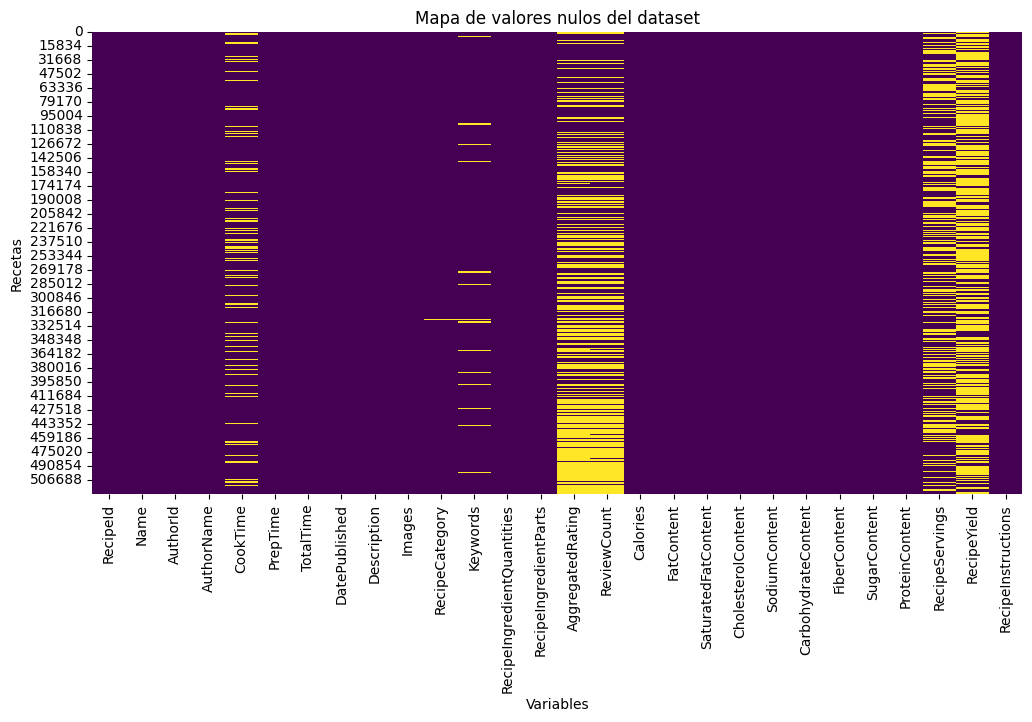

In [ ]:
# Heatmap de valores nulos

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de valores nulos del dataset")
plt.xlabel("Variables")
plt.ylabel("Recetas")
plt.show()

Este heatmap de valores nulos nos ofrece una representación visual rápida de la integridad de los datos en tu DataFrame.

Las líneas horizontales claras indican las columnas con un número significativo de valores faltantes. Por ejemplo, `AggregatedRating`, `ReviewCount` y `RecipeYield` muestran franjas grandes y claras, lo que confirma que estas columnas tienen una alta proporción de datos nulos.

Las columnas más oscuras, como las de contenido nutricional (`Calories`, `FatContent`, etc.), confirman que están mayormente completas.

In [ ]:
df.isna().sum()

,0
RecipeId,0
Name,0
AuthorId,0
AuthorName,0
CookTime,82545
PrepTime,0
TotalTime,0
DatePublished,0
Description,5
Images,1


La salida de `df.isna().sum()` nos muestra la cantidad de valores nulos por columna. Observamos que la información nutricional clave como `Calories`, `FatContent`, `CarbohydrateContent` y `ProteinContent` está completa. Sin embargo, hay un número considerable de valores faltantes en campos como `AggregatedRating`, `ReviewCount`, `RecipeYield` y `RecipeServings`, entre otros, lo cual es común en datasets tan grandes y variados.

### 4.3. Exploración de duplicados

In [ ]:
# Recetas duplicadas
duplicados = df["Name"].value_counts()
print(f"\nRecetas duplicadas (mismo nombre):")
print(duplicados[duplicados > 1])


Recetas duplicadas (mismo nombre):
Name
Banana Bread                         186
Chicken Enchiladas                   132
Beef Stroganoff                      126
Chocolate Chip Cookies               115
Sweet Potato Casserole               113
                                    ... 
Ham and Sweet Potato Hash              2
Chicken, Lemon and Dill With Orzo      2
The Dove's Nest Texas Chowder          2
Chocolate Dipped Strawberries          2
Chicken With Garlic Cream Sauce        2
Name: count, Length: 32600, dtype: int64


Podemos ver que existen bastantes recetas duplicadas (aquellas con el mismo nombre) en este dataset. Más adelante, en la fase de limpieza del dataset eliminaremos estos duplicados para quedarnos solo con una instancia de cada receta única. Esto ayuda a evitar que el modelo de recomendación se sesgue o favorezca a recetas que aparecen múltiples veces, asegurando que cada receta tenga la misma oportunidad de ser recomendada.

### 4.4. Resumen estadístico

In [ ]:
df.describe()

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,269294.000000,275028.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,339606.000000
mean,271821.436970,4.572585e+07,4.632014,5.227784,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,8.606191
std,155495.878422,2.929714e+08,0.641934,20.381347,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,114.319809
min,38.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,4.500000,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,5.000000,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


En este resumen estadístico de las columnas numéricas del DataFrame. Podemos observar lo siguiente:

- Valoraciones (`AggregatedRating`) y Conteo de Reseñas (`ReviewCount`): Las recetas que tienen valoraciones y reseñas tienden a tener una calificación alta, con una media de 4.63 sobre 5.0. Sin embargo, hay una gran cantidad de valores nulos en estas columnas, y el número de reseñas varía mucho, con algunas recetas teniendo miles de reseñas.

- Valores Nutricionales (`Calories`, `FatContent`, `CarbohydrateContent`, `ProteinContent`, etc.): Todas estas columnas tienen datos completos. Sin embargo, los valores máximos son extremadamente altos (ej. Calories hasta 612,854.6, FatContent hasta 64,368.1), lo que sugiere la presencia de valores atípicos (outliers) o errores en los datos que podrían necesitar limpieza para evitar sesgos en el análisis o modelado.

- Porciones (`RecipeServings`): Esta columna también muestra un rango muy amplio, con un máximo de 32,767 porciones, lo que es irrealista y probablemente sea un error de entrada de datos o un outlier significativo. La media es de 8.6, pero la mediana es 6.0, indicando que la mayoría de las recetas son para menos porciones, y los valores altos extremos están sesgando la media.

Sabiendo esto, se nos pone por delante una clara necesidad de revisar y limpiar los valores extremos en las columnas numéricas para asegurar la calidad de los datos.

### 4.5. Visualización de datos

##### 4.5.1. Distribución de recetas por número de ingredientes


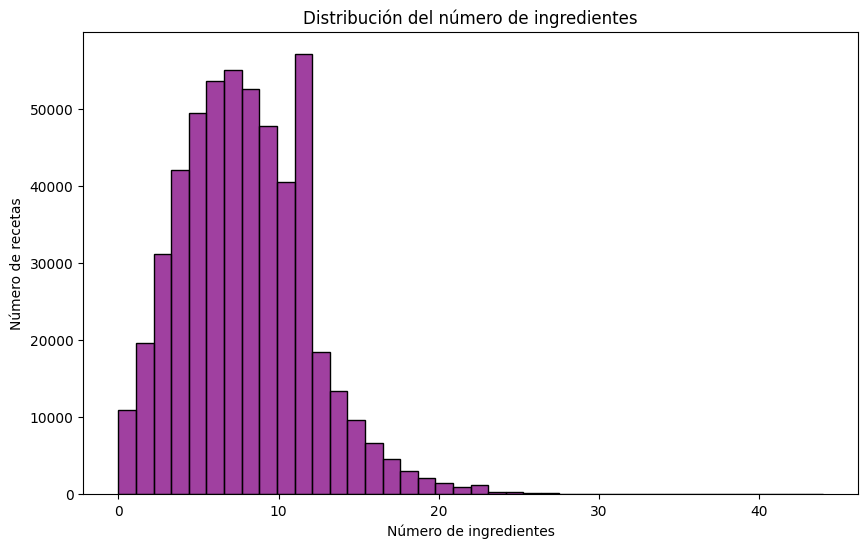

In [ ]:
# Histograma numero de ingredientes

n_ingredients_list = []

for recipe in df["RecipeIngredientParts"]:
    if isinstance(recipe, str):
        found = re.findall(r'"([^"]*)"', recipe)
        n_ingredients_list.append(len(found))
    else:
        # Si es nulo o no es texto, añadimos 0
        n_ingredients_list.append(0)

plt.figure(figsize=(10, 6))

sns.histplot(x=n_ingredients_list, bins=40, color="purple")

plt.title("Distribución del número de ingredientes")
plt.xlabel("Número de ingredientes")
plt.ylabel("Número de recetas")
plt.show()

Este histograma muestra la distribución del número de ingredientes por receta.

Se puede observar que la mayoría de las recetas tienen un número relativamente normal de ingredientes, concentrándose en el rango de 5 a 12 ingredientes.

##### 4.5.1 Análisis nutricional

Distribución de macronutrientes con histogramas de:

- calories
- fat
- protein
- carbohydrates

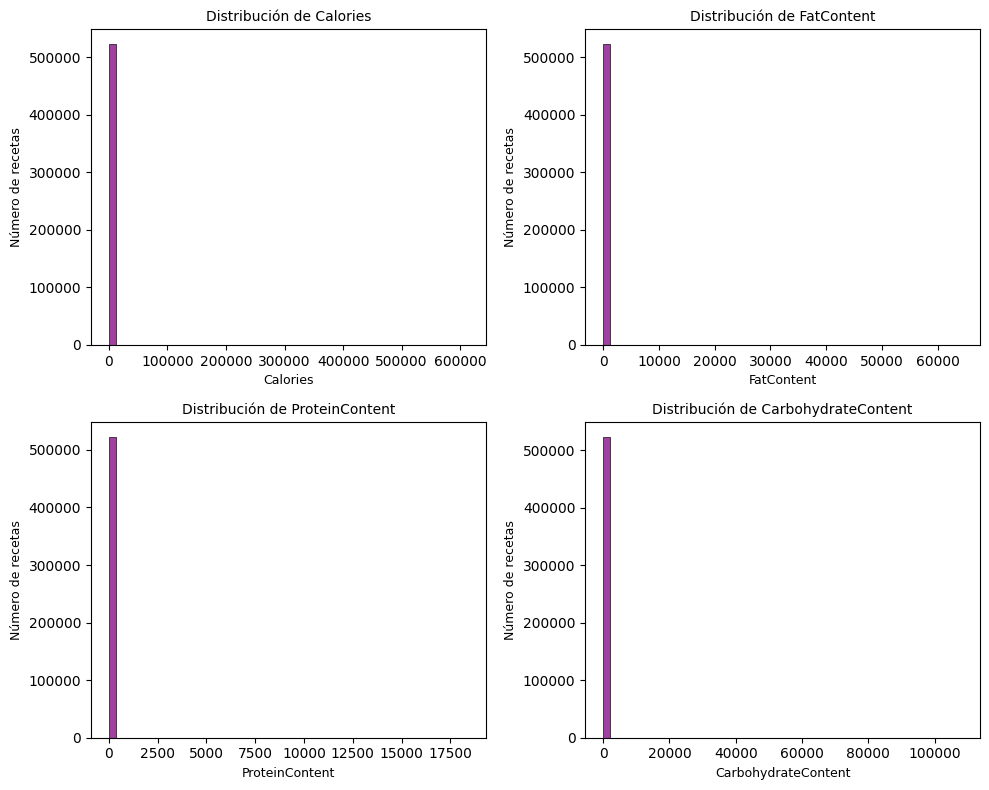

In [ ]:
# Histograma de macronutrientes

nutrients = ["Calories", "FatContent", "ProteinContent", "CarbohydrateContent"]

# Creamos una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Aplanamos la matriz de ejes para iterar fácilmente
axes = axes.flatten()

for i, col in enumerate(nutrients):
    sns.histplot(df[col], bins=50, ax=axes[i], color="purple")

    axes[i].set_title(f"Distribución de {col}", fontsize=10)
    axes[i].set_xlabel(col, fontsize=9)
    axes[i].set_ylabel("Número de recetas", fontsize=9)

plt.tight_layout()
plt.show()

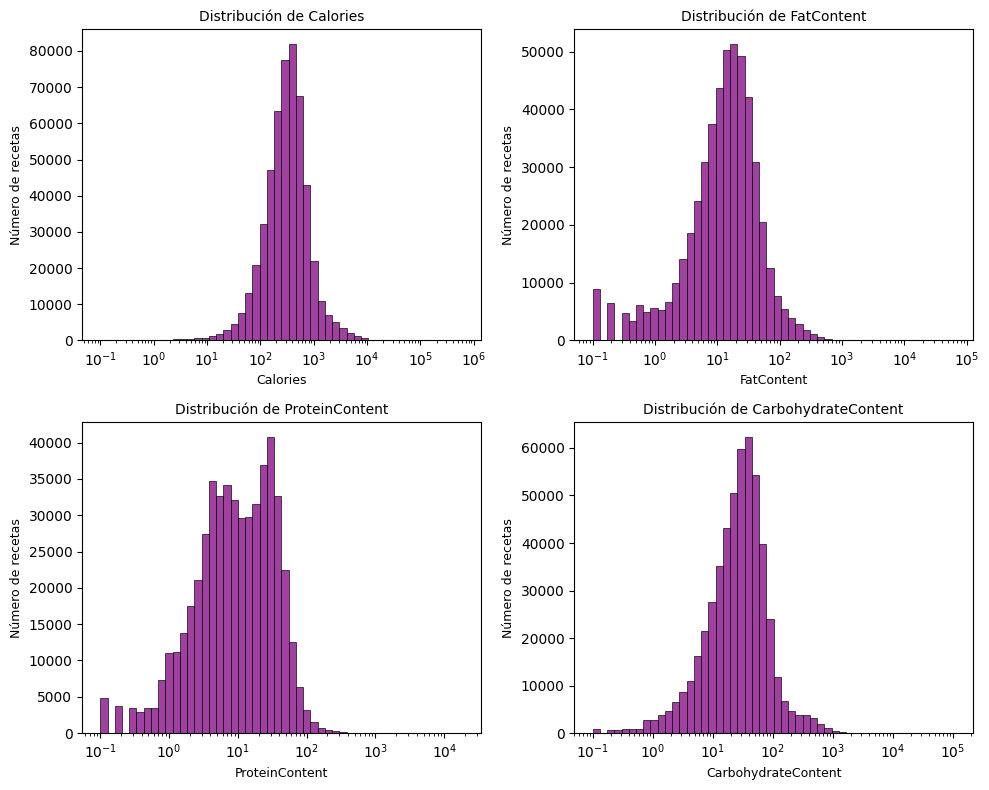

In [ ]:
# Forma logaritmica
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Aplanamos la matriz de ejes para iterar fácilmente
axes = axes.flatten()

for i, col in enumerate(nutrients):
    sns.histplot(df[col], bins=50, ax=axes[i], log_scale=True, color="purple")

    axes[i].set_title(f"Distribución de {col}", fontsize=10)
    axes[i].set_xlabel(col, fontsize=9)
    axes[i].set_ylabel("Número de recetas", fontsize=9)

plt.tight_layout()
plt.show()

Relación entre macronutrientes con scatter plots de:

- calories vs protein
- calories vs fat
- fat vs carbohydrates

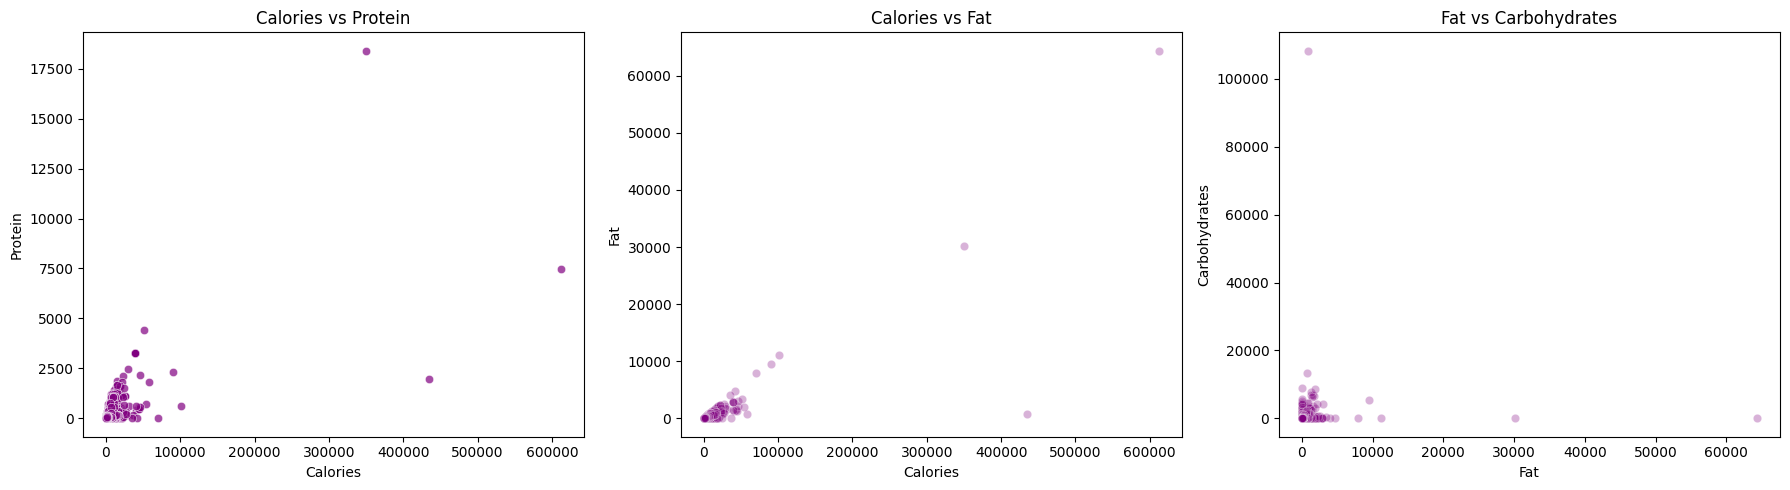

In [ ]:
# Relaciones entre macronutrientes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Calories vs Protein
sns.scatterplot(data=df, x="Calories", y="ProteinContent", alpha=0.7, ax=axes[0], color="purple")
axes[0].set_title("Calories vs Protein")
axes[0].set_xlabel("Calories")
axes[0].set_ylabel("Protein")

# 2. Calories vs Fat
sns.scatterplot(data=df, x="Calories", y="FatContent", alpha=0.3, ax=axes[1], color="purple")
axes[1].set_title("Calories vs Fat")
axes[1].set_xlabel("Calories")
axes[1].set_ylabel("Fat")

# 3. Fat vs Carbohydrates
sns.scatterplot(data=df, x="FatContent", y="CarbohydrateContent", alpha=0.3, ax=axes[2], color="purple")
axes[2].set_title("Fat vs Carbohydrates")
axes[2].set_xlabel("Fat")
axes[2].set_ylabel("Carbohydrates")

# Ajuste fino para que los títulos y etiquetas no se solapen
plt.tight_layout()
plt.show()

##### 4.5.3. Análisis de ingredientes

Frecuencia de ingredientes con Barplot top-40 ingredientes

Número de ingredientes vs nutrición con Scatter:

- n_ingredients vs calories
- n_ingredients vs fat

/tmp/ipython-input-4019137810.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ingredients_df, y="ingredient", x="count", palette="viridis", legend=False)


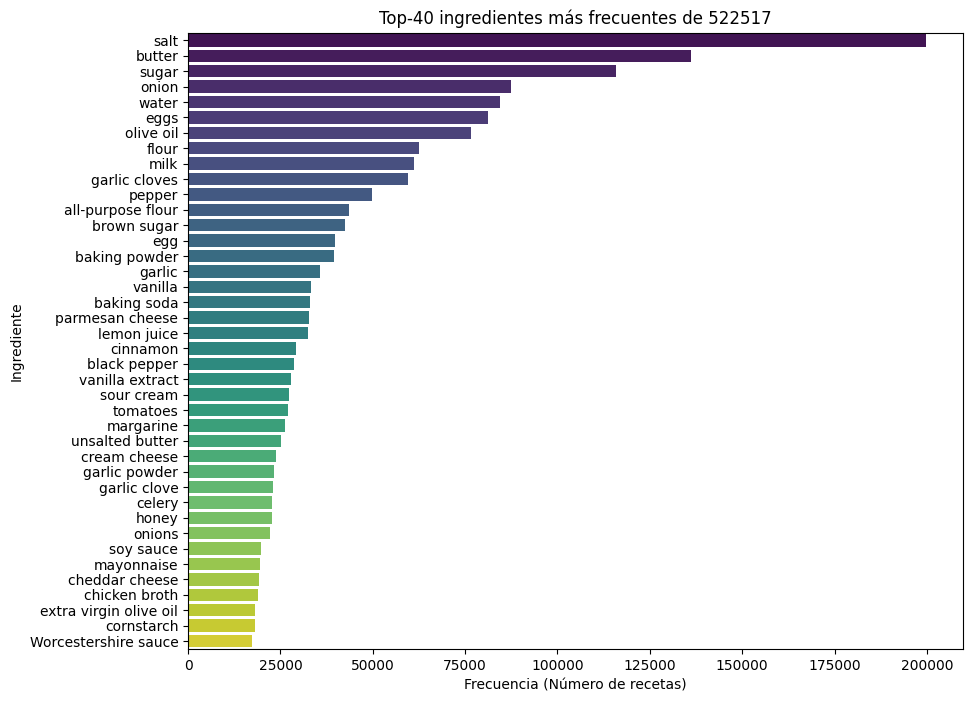

In [ ]:
# 1. Extraemos los ingredientes en forma de listas reales
# Usamos regex para sacar lo que está entre comillas: "harina", "huevo"...
def get_list(text):
    if isinstance(text, str):
        return re.findall(r'"([^"]*)"', text)
    return []

# Creamos una serie donde cada celda es una lista de ingredientes
all_ingredients_series = df["RecipeIngredientParts"].apply(get_list)

# 2. "Explotamos" las listas y contamos (esta es la alternativa a Counter)
# .explode() convierte cada elemento de la lista en una fila propia
# .value_counts() cuenta cuántas veces aparece cada ingrediente
top_ingredients = all_ingredients_series.explode().value_counts().head(40)

# 3. Convertimos el resultado en un DataFrame para graficar
ingredients_df = top_ingredients.reset_index()
ingredients_df.columns = ["ingredient", "count"]

# 4. Gráfico
plt.figure(figsize=(10, 8))
sns.barplot(data=ingredients_df, y="ingredient", x="count", palette="viridis", legend=False)

plt.title(f"Top-40 ingredientes más frecuentes de {len(all_ingredients_series)}")
plt.xlabel("Frecuencia (Número de recetas)")
plt.ylabel("Ingrediente")
plt.show()

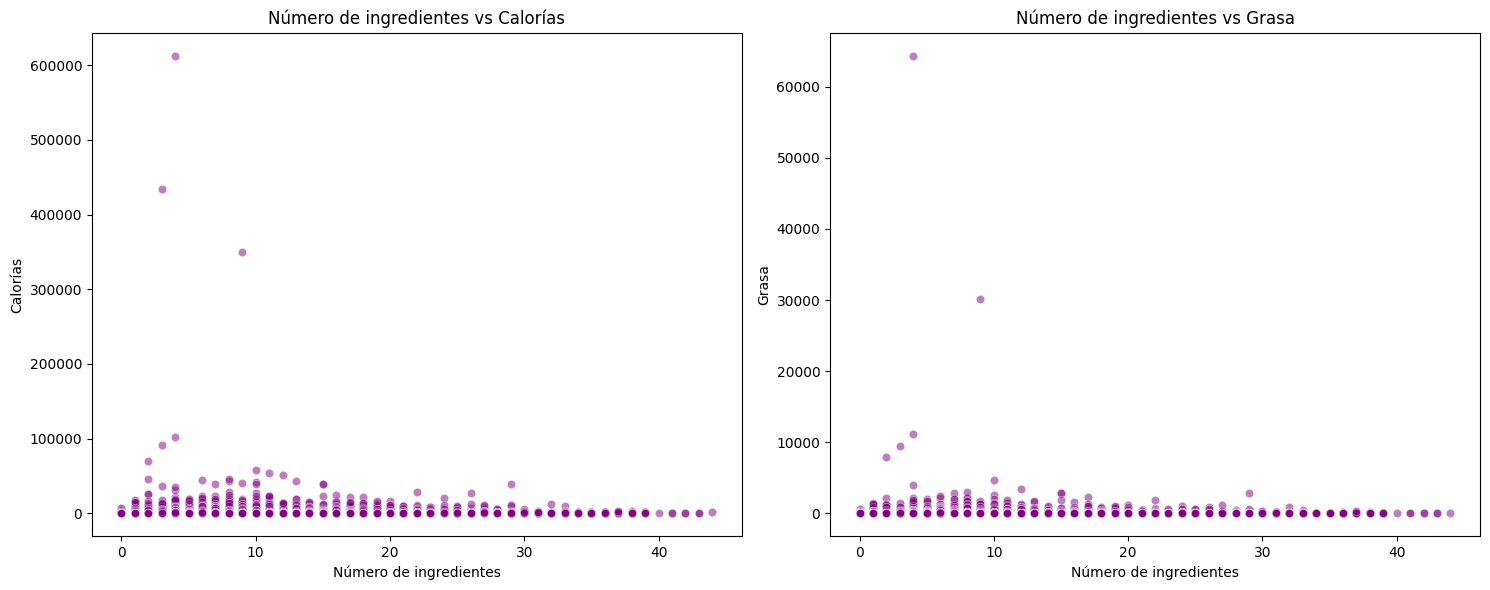

In [ ]:
# Número de ingredientes vs nutrición
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Gráfico de Calorías
sns.scatterplot(x=n_ingredients_list, y=df["Calories"], alpha=0.5, ax=axes[0], color="purple")
axes[0].set_title("Número de ingredientes vs Calorías")
axes[0].set_xlabel("Número de ingredientes")
axes[0].set_ylabel("Calorías")

# 2. Gráfico de Grasa
sns.scatterplot(x=n_ingredients_list, y=df["FatContent"], alpha=0.5, ax=axes[1], color="purple")
axes[1].set_title("Número de ingredientes vs Grasa")
axes[1].set_xlabel("Número de ingredientes")
axes[1].set_ylabel("Grasa")

plt.tight_layout()
plt.show()

##### 4.5.4. Analisis de tags y categorias dieteticas

Frecuencia de tags con Barplot top-30 tags y Wordcloud

/tmp/ipython-input-1168448684.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


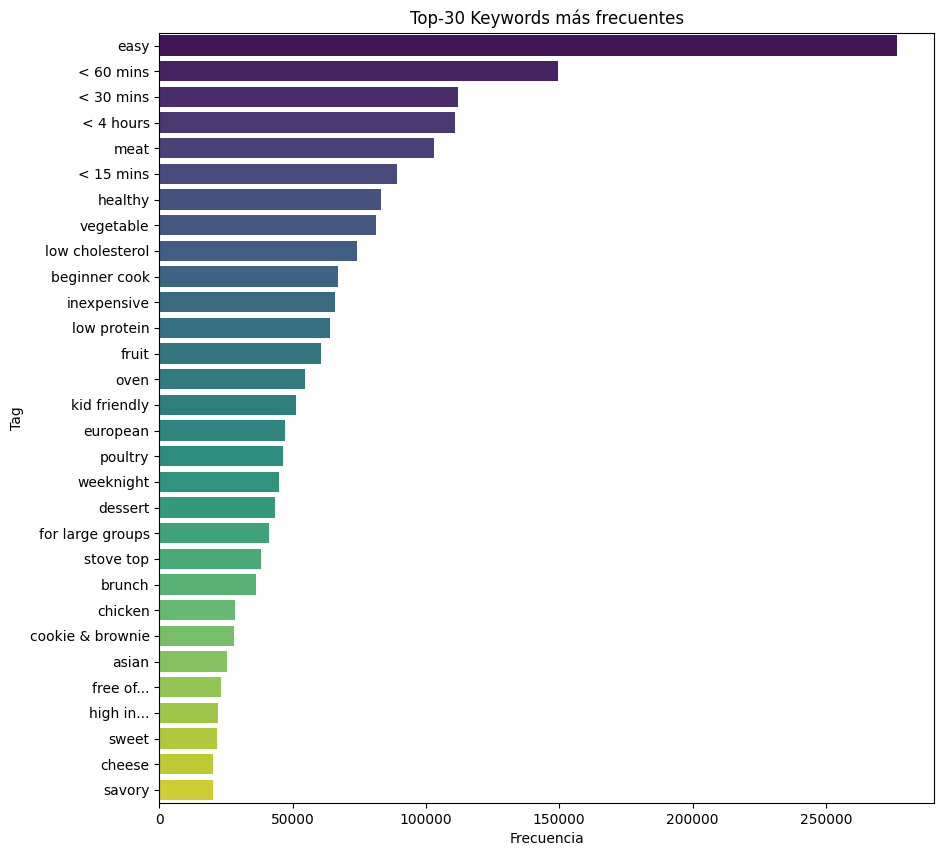

In [ ]:
# Frecuencia de tags
flat_tags_list = []

for tag_string in df["Keywords"]:
    if isinstance(tag_string, str):
        tags = re.findall(r'"([^"]*)"', tag_string)

        for t in tags:
            flat_tags_list.append(t.strip().lower())

tag_counts = pd.Series(flat_tags_list).value_counts()

top_tags_df = tag_counts.head(30).reset_index()
top_tags_df.columns = ["tag", "count"]

plt.figure(figsize=(10, 10))
sns.barplot(
    data=top_tags_df,
    y="tag",
    x="count",
    palette="viridis",
    legend=False
)

plt.title("Top-30 Keywords más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Tag")
plt.show()

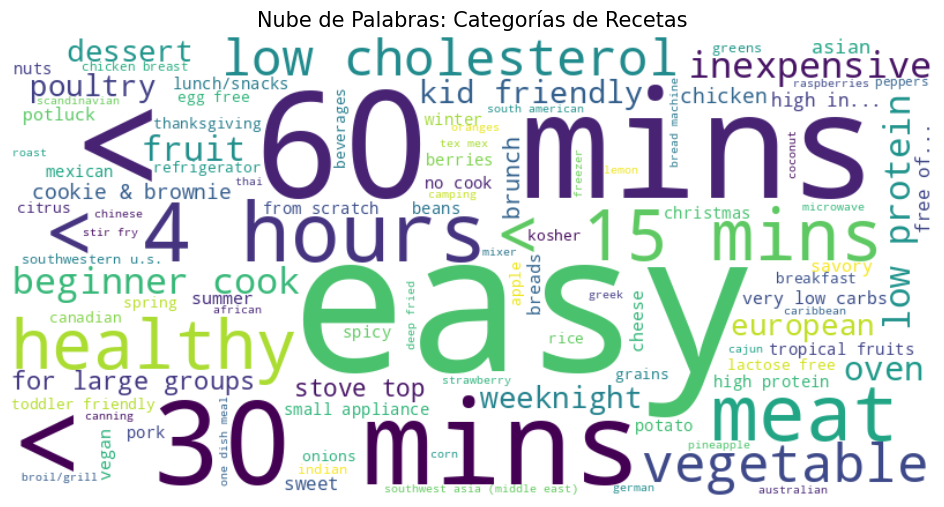

In [ ]:
# 1. Convertimos nuestra serie de frecuencias a un diccionario (lo que WordCloud espera)
# tag_counts ya tiene los tags como índice y las frecuencias como valores
tag_freq_dict = tag_counts.to_dict()

# 2. Configuramos y generamos la nube de palabras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis", # Añadimos un mapa de colores para que combine con tus barplots
    max_words=100       # Limitamos a las 100 palabras más frecuentes para que sea legible
).generate_from_frequencies(tag_freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") # Es importante quitar los ejes en una nube de palabras
plt.title("Nube de Palabras: Categorías de Recetas", fontsize=15)
plt.show()

Frecuencia de tags con Barplot top-30 tags

/tmp/ipython-input-2876690570.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


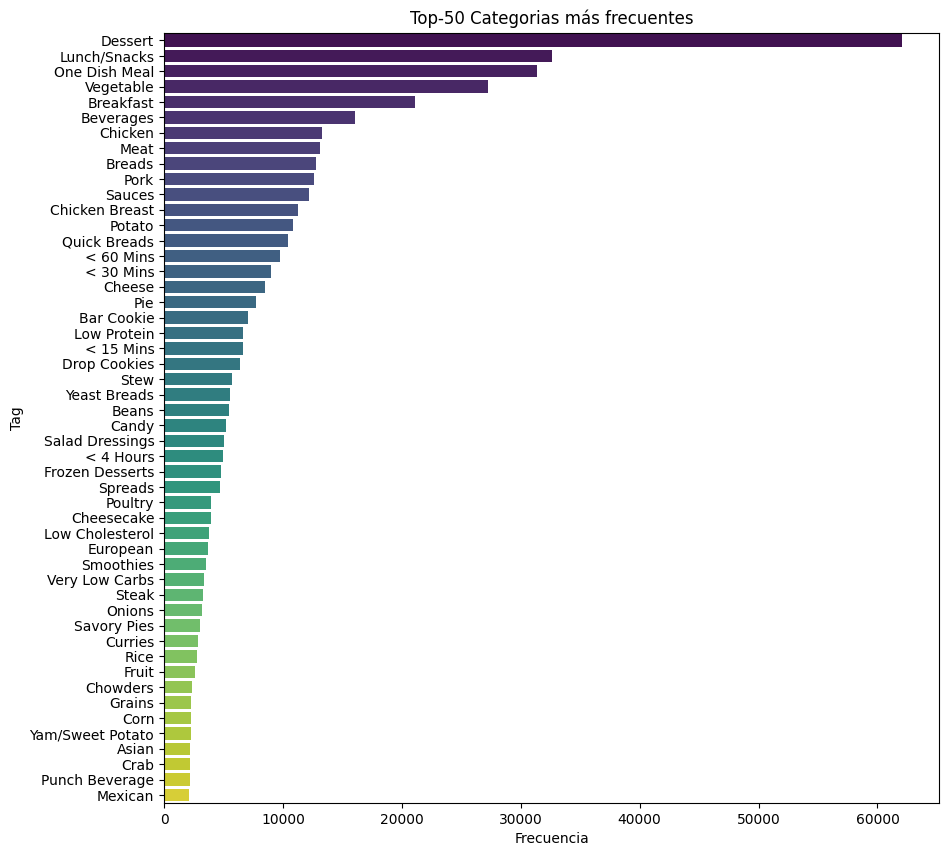

In [ ]:
# Frecuencia de categoria
tag_counts = df["RecipeCategory"].value_counts()

top_tags_df = tag_counts.head(50).reset_index()
top_tags_df.columns = ["tag", "count"]

plt.figure(figsize=(10, 10))
sns.barplot(
    data=top_tags_df,
    y="tag",
    x="count",
    palette="viridis",
    legend=False
)

plt.title("Top-50 Categorias más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Tag")
plt.show()


Nutrición por tipo de dieta con boxplots de:

- calorias por tipo de dieta
- proteina por tipo de dieta

/tmp/ipython-input-1371969775.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=diet_df, x="diet_type", y="Calories", palette="viridis")


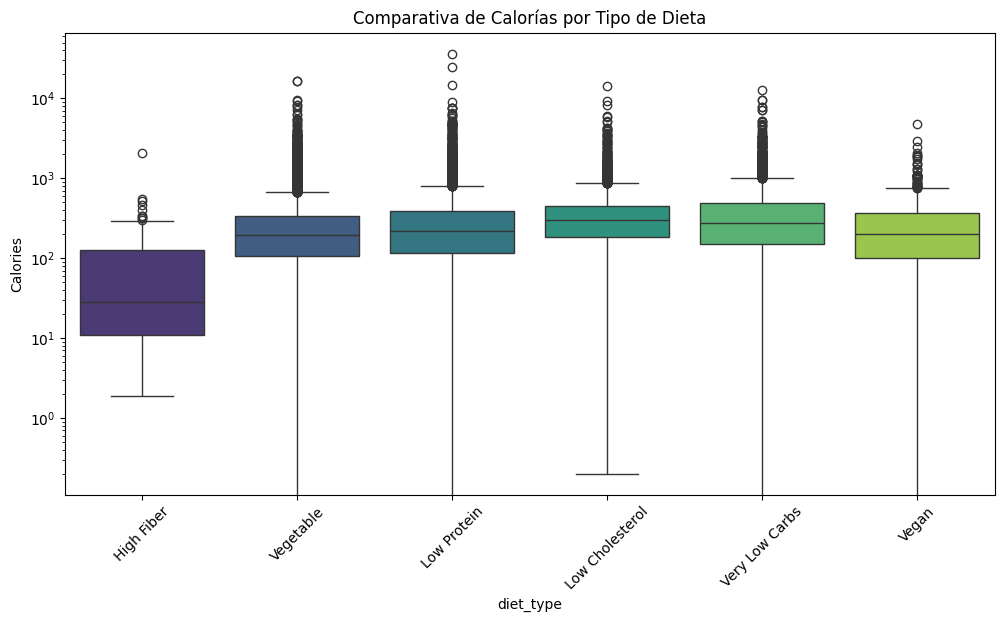

In [ ]:
diet_tags = ["High Fiber", "Vegetable", "Low Protein", "Low Cholesterol", "Very Low Carbs", "Vegan"]

diet_data = []

for diet in diet_tags:
    mask = df["RecipeCategory"].str.contains(diet, case=False, na=False)

    subset = df[mask].copy()

    subset["diet_type"] = diet
    diet_data.append(subset)

# 3. Concatenamos todo en un nuevo DataFrame
diet_df = pd.concat(diet_data, ignore_index=True)


plt.figure(figsize=(12, 6))
# Comparar calorías por tipo de dieta
sns.boxplot(data=diet_df, x="diet_type", y="Calories", palette="viridis")
plt.yscale('log') # Usamos log porque las calorías varían mucho
plt.title("Comparativa de Calorías por Tipo de Dieta")
plt.xticks(rotation=45)
plt.show()

### 4.6. Detección de inconsistencias nutricionales

In [ ]:
# Valores nutricionales incoherentes (ej: Calories = 0 pero Protein/Carbs/Fat > 0)
incoherentes = df[(df["Calories"] == 0) &
                   ((df["ProteinContent"] > 0) |
                    (df["FatContent"] > 0) |
                    (df["CarbohydrateContent"] > 0))]
print(f"\nRecetas con Calories=0 pero macros>0: {len(incoherentes)}")

if len(incoherentes) > 0:
    print(incoherentes[["Name", "Calories", "ProteinContent", "FatContent", "CarbohydrateContent"]])


Recetas con Calories=0 pero macros>0: 7
                                              Name  Calories  ProteinContent  \
76147                     Light Cranberry Spritzer       0.0             0.3   
149855               Low Cal Diet Soda Fruit Mixer       0.0             0.3   
219108                         Sparkling Peach Tea       0.0             0.1   
224419          Creamy Iced Vanilla Caramel Coffee       0.0             0.2   
226353                       Orange-Berry Sparkler       0.0             0.1   
298371                          Low Carb Milkshake       0.0             0.5   
307172  Orange Cream Float(Hungry Girl) 1 Ww Point       0.0             0.3   

        FatContent  CarbohydrateContent  
76147          0.0                  0.0  
149855         0.0                  0.0  
219108         0.0                  0.0  
224419         0.0                  0.0  
226353         0.0                  0.0  
298371         0.0                  0.0  
307172         0.0      

Hay 7 recetas en el dataset donde el valor de `Calories` es 0, pero a pesar de ello, tienen contenido positivo en al menos uno de los macronutrientes (`ProteinContent`, `FatContent`, `CarbohydrateContent`). Esto nos indica una inconsistencia en los datos, ya que las calorías deberían derivarse de la presencia de estos macronutrientes, y por tanto deberán ser manejados (por ejemplo, eliminados o corregidos) para asegurar la fiabilidad del análisis o del modelo.

In [ ]:
# Valores nutricinales que no suman correctamente las calorías
# Nota: 1g proteína/carbs = 4 kcal, 1g grasa = 9 kcal (aproximado)
df["expected_calories"] = (df["ProteinContent"] * 4 +
                            df["CarbohydrateContent"] * 4 +
                            df["FatContent"] * 9)
df["calorie_deviation"] = abs(df["Calories"] - df["expected_calories"]) / (df["Calories"] + 1)

print(f"\nDesviación promedio en calorías: {df["calorie_deviation"].mean():.2f}")
print(f"Recetas con desviación > 50%: {(df["calorie_deviation"] > 0.5).sum()}")


Desviación promedio en calorías: 0.04
Recetas con desviación > 50%: 6071


- **Desviación promedio en calorías**: 0.04
  - Nos indica que, en general, el cálculo de calorías a partir de los macronutrientes (proteínas, carbohidratos y grasas) es bastante consistente con el valor de `Calories` reportado en el dataset. Una desviación promedio tan baja (4%) sugiere que la mayoría de las recetas tienen una buena coherencia nutricional.

- **Recetas con desviación > 50%**: 6071
  - Aunque la desviación promedio es baja, hay un número significativo de 6071 recetas donde las calorías calculadas difieren en más de un **50%** de las calorías reportadas. Esto apunta a la existencia de **valores atípicos** o **errores** importantes en los datos nutricionales de estas recetas específicas, que podrían requerir una limpieza o revisión más profunda, ya que podrían sesgar cualquier análisis o modelo que dependa de una alta precisión en los valores nutricionales.

## **5. Limpieza del dataset**

### 5.1. Selección de columnas

- Seleccionamos primero las columnas necesarias para el dataset que guardaremos y usaremos en la aplicación final.

In [ ]:
cols_valid = ["Name", "Images", "RecipeIngredientParts", "Calories", "FatContent", "CarbohydrateContent", "ProteinContent",
              "RecipeServings", "expected_calories", "calorie_deviation"]
df = df[cols_valid].copy()

In [ ]:
df.head()

,Name,Images,RecipeIngredientParts,Calories,FatContent,CarbohydrateContent,ProteinContent,RecipeServings,expected_calories,calorie_deviation
0,Low-Fat Berry Blue Frozen Dessert,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""blueberries"", ""granulated sugar"", ""vanilla ...",170.9,2.5,37.1,3.2,4.0,183.7,0.074462
1,Biryani,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""saffron"", ""milk"", ""hot green chili peppers""...",1110.7,58.8,84.4,63.4,6.0,1120.4,0.008725
2,Best Lemonade,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",311.1,0.2,81.5,0.3,4.0,329.0,0.057353
3,Carina's Tofu-Vegetable Kebabs,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",536.1,24.0,64.2,29.3,2.0,590.0,0.100354
4,Cabbage Soup,"""https://img.sndimg.com/food/image/upload/w_55...","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",103.6,0.4,25.1,4.3,4.0,121.2,0.168260


### 5.2. Eliminación de nulos

In [ ]:
df.isna().sum()

,0
Name,0
Images,1
RecipeIngredientParts,0
Calories,0
FatContent,0
CarbohydrateContent,0
ProteinContent,0
RecipeServings,182911
expected_calories,0
calorie_deviation,0


In [ ]:
df.dropna(inplace=True)
df.isna().sum()

,0
Name,0
Images,0
RecipeIngredientParts,0
Calories,0
FatContent,0
CarbohydrateContent,0
ProteinContent,0
RecipeServings,0
expected_calories,0
calorie_deviation,0


In [ ]:
df.shape

(339605, 10)

Se queda en **339605  registros** de los 522514 iniciales.

### 5.3. Eliminación de duplicados

In [ ]:
duplicados = df["Name"].value_counts()
print(duplicados[duplicados > 1])

Name
Beef Stroganoff                88
Banana Bread                   87
Chicken Enchiladas             83
Apple Crisp                    70
Chili                          66
                               ..
Butter Pecan Banana Muffins     2
Greek Meatball Kabobs           2
Cran-Orange Icebox Cookies      2
Frozen Yogurt Pie               2
Onion Bhajis                    2
Name: count, Length: 19377, dtype: int64


In [ ]:
df.drop_duplicates(["Name"], inplace=True)

In [ ]:
duplicados = df["Name"].value_counts()
print(f"\nRecetas duplicadas después de eliminar duplicados:")
print(duplicados[duplicados > 1])


Recetas duplicadas después de eliminar duplicados:
Series([], Name: count, dtype: int64)


In [ ]:
df.shape

(295233, 10)

El dataframe se queda en **295233 registros**.

### 5.4. Eliminación de datos/valores incosistentes

In [ ]:
# Aplicamos umbrales realistas basados en nutrición
df = df[
    (df["Calories"] > 0) & (df["Calories"] < 2000) &  # por serving
    (df["FatContent"] >= 0) & (df["FatContent"] < 200) &
    (df["CarbohydrateContent"] >= 0) & (df["CarbohydrateContent"] < 500) &
    (df["ProteinContent"] >= 0) & (df["ProteinContent"] < 200) &
    (df["RecipeServings"] > 0) & (df["RecipeServings"] <= 24)
].copy()

print(f"Filas después del filtrado: {len(df)}")
print(f"Estadísticas después del filtrado:")
print(df[["Calories", "FatContent", "CarbohydrateContent", "ProteinContent", "RecipeServings"]].describe())

Filas después del filtrado: 281216
Estadísticas después del filtrado:
            Calories     FatContent  CarbohydrateContent  ProteinContent  \
count  281216.000000  281216.000000        281216.000000    281216.00000   
mean      355.213155      17.784826            32.992553        15.87774   
std       260.939866      18.318584            30.105688        16.82217   
min         0.100000       0.000000             0.000000         0.00000   
25%       174.600000       5.600000            12.000000         3.80000   
50%       297.400000      13.000000            26.300000         9.40000   
75%       464.600000      24.100000            45.100000        24.40000   
max      1998.600000     199.700000           499.300000       196.70000   

       RecipeServings  
count    281216.00000  
mean          6.72290  
std           4.69413  
min           1.00000  
25%           4.00000  
50%           6.00000  
75%           8.00000  
max          24.00000  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 281216 entries, 0 to 522514
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Name                   281216 non-null  object 
 1   Images                 281216 non-null  object 
 2   RecipeIngredientParts  281216 non-null  object 
 3   Calories               281216 non-null  float64
 4   FatContent             281216 non-null  float64
 5   CarbohydrateContent    281216 non-null  float64
 6   ProteinContent         281216 non-null  float64
 7   RecipeServings         281216 non-null  float64
 8   expected_calories      281216 non-null  float64
 9   calorie_deviation      281216 non-null  float64
dtypes: float64(7), object(3)
memory usage: 23.6+ MB


In [ ]:
df.head()

,Name,Images,RecipeIngredientParts,Calories,FatContent,CarbohydrateContent,ProteinContent,RecipeServings,expected_calories,calorie_deviation
0,Low-Fat Berry Blue Frozen Dessert,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""blueberries"", ""granulated sugar"", ""vanilla ...",170.9,2.5,37.1,3.2,4.0,183.7,0.074462
1,Biryani,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""saffron"", ""milk"", ""hot green chili peppers""...",1110.7,58.8,84.4,63.4,6.0,1120.4,0.008725
2,Best Lemonade,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",311.1,0.2,81.5,0.3,4.0,329.0,0.057353
3,Carina's Tofu-Vegetable Kebabs,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",536.1,24.0,64.2,29.3,2.0,590.0,0.100354
4,Cabbage Soup,"""https://img.sndimg.com/food/image/upload/w_55...","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",103.6,0.4,25.1,4.3,4.0,121.2,0.168260


In [ ]:
# Eliminamos aquellos registros con una desviación típica mayor del 50% en las calorias
df = df[df["calorie_deviation"] <= 0.5].copy()
print(f"Después de filtrar desviaciones altas: {len(df)} recetas")

Después de filtrar desviaciones altas: 276694 recetas


## **6. Transformación y Procesamiento de Datos**

### 6.1. Ajuste de Valores Nutricionales por Porción

In [ ]:
def extract_serving(serving_value):
    """Extrae y valida el valor de serving."""
    try:
        serving = float(serving_value)
        return serving if serving > 0 else 1.0
    except (ValueError, TypeError):
        return 1.0

df["RecipeServings"] = df["RecipeServings"].apply(extract_serving)

In [ ]:
# aplicamos la función a los campos nutricionales que usaremos en el entrenamiento
cols = ["Calories", "FatContent", "CarbohydrateContent", "ProteinContent"]
df[cols] = df[cols].div(df["RecipeServings"], axis=0).round(2)
df.head()

,Name,Images,RecipeIngredientParts,Calories,FatContent,CarbohydrateContent,ProteinContent,RecipeServings,expected_calories,calorie_deviation
0,Low-Fat Berry Blue Frozen Dessert,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""blueberries"", ""granulated sugar"", ""vanilla ...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462
1,Biryani,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""saffron"", ""milk"", ""hot green chili peppers""...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725
2,Best Lemonade,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353
3,Carina's Tofu-Vegetable Kebabs,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354
4,Cabbage Soup,"""https://img.sndimg.com/food/image/upload/w_55...","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260


### 6.2. Limpieza Final de Columnas

- Normalizamos el campo de `Images` y eliminamos aquellos campos con valores `character(0)`.

In [ ]:
# Limpieza de URLs de Imágenes
df["Images"] = (
    df["Images"]
    .astype(str)
    .str.replace(r'^c\("', '', regex=True)   # elimina c(" al inicio
    .str.replace(r'"\)$', '', regex=True)    # elimina ") al final
    .str.replace(r'\"', '', regex=True)      # elimina comillas internas
)


In [ ]:
df.head()

,Name,Images,RecipeIngredientParts,Calories,FatContent,CarbohydrateContent,ProteinContent,RecipeServings,expected_calories,calorie_deviation
0,Low-Fat Berry Blue Frozen Dessert,https://img.sndimg.com/food/image/upload/w_555...,"c(""blueberries"", ""granulated sugar"", ""vanilla ...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462
1,Biryani,https://img.sndimg.com/food/image/upload/w_555...,"c(""saffron"", ""milk"", ""hot green chili peppers""...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725
2,Best Lemonade,https://img.sndimg.com/food/image/upload/w_555...,"c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353
3,Carina's Tofu-Vegetable Kebabs,https://img.sndimg.com/food/image/upload/w_555...,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354
4,Cabbage Soup,https://img.sndimg.com/food/image/upload/w_555...,"c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260


In [ ]:
# Comrpobamos cuantas imágenes están bien normalizadas
TARGET_PREFIX = "http"

num_correctas = df["Images"].dropna().str.startswith(TARGET_PREFIX).sum()

# Total filas
total_filas = len(df)

# Porcentaje correcto
porcentaje_correctas = num_correctas / total_filas * 100

print(f"Filas correctas: {num_correctas} / {total_filas} ({porcentaje_correctas:.2f}%)")


Filas correctas: 91361 / 276694 (33.02%)


In [ ]:
# Booleano de filas correctas
mask_correct = df["Images"].dropna().str.startswith(TARGET_PREFIX)

# Filas incorrectas
incorrectas = df.loc[~mask_correct, "Images"]
print(incorrectas.head(10))
print(f"Total URLs incorrectas: {len(incorrectas)}")


5     character(0)
10    character(0)
13    character(0)
19    character(0)
22    character(0)
24    character(0)
25    character(0)
26    character(0)
28    character(0)
29    character(0)
Name: Images, dtype: object
Total URLs incorrectas: 185333


In [ ]:
# Nos quedamos solo con las filas con URLs bien formateadas
df = df[mask_correct].copy()


In [ ]:
print("Filas restantes:", len(df))
print("Ejemplo URLs:", df["Images"].head(5).tolist())


Filas restantes: 91361
Ejemplo URLs: ['https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/YUeirxMLQaeE1h3v3qnM_229%20berry%20blue%20frzn%20dess.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/AFPDDHATWzQ0b1CDpDAT_255%20berry%20blue%20frzn%20dess.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/UYgf9nwMT2SGGJCuzILO_228%20berry%20blue%20frzn%20dess.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/PeBMJN2TGSaYks2759BA_20140722_202142.jpg, \nhttps://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/picuaETeN.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/pictzvxW5.jpg', 'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/39/picM9Mhnw.jpg, https://img.sn

- Hacemos lo mismo con RecipeIngredientParts: Eliminamos los registros con valor character(0) en el campo de RecipeIngredientParts.

In [ ]:
df.loc[df["RecipeIngredientParts"] == "character(0)"]

,Name,Images,RecipeIngredientParts,Calories,FatContent,CarbohydrateContent,ProteinContent,RecipeServings,expected_calories,calorie_deviation
344,Frozen Cappuccino,https://img.sndimg.com/food/image/upload/w_555...,character(0),3.60,0.30,0.00,0.20,1.0,3.5,0.021739
1691,Almond Joy Fudge Brownies,https://img.sndimg.com/food/image/upload/w_555...,character(0),27.16,1.31,3.77,0.35,15.0,424.5,0.041871
4582,Sweet 'N' Spicy Onion Glaze,https://img.sndimg.com/food/image/upload/w_555...,character(0),603.25,6.35,143.20,4.55,2.0,1296.3,0.074369
6866,Lemon Soda,https://img.sndimg.com/food/image/upload/w_555...,character(0),147.80,0.10,37.50,0.20,1.0,151.7,0.026210
9491,Easy punch,https://img.sndimg.com/food/image/upload/w_555...,character(0),48.97,0.08,12.18,0.16,10.0,500.8,0.022621
...,...,...,...,...,...,...,...,...,...,...
510947,Party Yum Punch,https://img.sndimg.com/food/image/upload/w_555...,character(0),5.00,0.00,1.27,0.01,19.0,96.8,0.018750
516484,Movie Theatre Popcorn Candy Bowl,https://img.sndimg.com/food/image/upload/w_555...,character(0),28.98,0.96,4.95,0.27,12.0,354.3,0.018635
516781,BB-8 Cookie Cake,https://img.sndimg.com/food/image/upload/w_555...,character(0),25.05,1.08,3.70,0.16,20.0,503.7,0.005378
517541,Easter Crockpot Candy,https://img.sndimg.com/food/image/upload/w_555...,character(0),25.69,1.77,2.10,0.58,24.0,640.1,0.038051


In [ ]:
df.drop(df[df["RecipeIngredientParts"] == "character(0)"].index, inplace=True)
df["RecipeIngredientParts"].value_counts(normalize=True)


,proportion
RecipeIngredientParts,
"""milk""",0.000780
"""butter""",0.000384
"""vanilla ice cream""",0.000384
"""water""",0.000362
"""cream cheese""",0.000318
...,...
"c(""frozen spinach"", ""white flour"", ""water"", ""salt"", ""eggs"", ""paprika"", ""plain yogurt"")",0.000011
"c(""strawberries"", ""light cream cheese"", ""confectioners' sugar"", ""vanilla extract"", ""fresh mint leaves"")",0.000011
"c(""butter"", ""cornstarch"", ""water"", ""brown sugar"", ""raisins"", ""lemon juice"", ""bananas"")",0.000011


- Limpiamos y normalizamos las cadenas de texto que representan ingredientes.

In [ ]:
def limpiar_c(x):
  """Limpia y formatea las cadenas de ingredientes, extrayendo elementos de estructuras tipo 'c("item1", "item2")'"""
  if pd.isna(x):
      return ""
  x = str(x)
  if x.startswith("c("):
      return ", ".join(re.findall(r'"([^"]+)"', x))
  return [x.replace('"', '').strip()]

In [ ]:
# Aplicamos la función
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].apply(limpiar_c)
df["RecipeIngredientParts"].value_counts(normalize=True)

# Explode la lista para tener un ingrediente por fila
ingredientes = df["RecipeIngredientParts"].explode()

# Contar frecuencia
freq = ingredientes.value_counts(normalize=True)  # porcentaje
print(freq.head(20))


RecipeIngredientParts
milk                   0.000780
butter                 0.000384
vanilla ice cream      0.000384
water                  0.000362
cream cheese           0.000318
mozzarella cheese      0.000275
cheese                 0.000242
eggs, water            0.000231
cranberry juice        0.000220
Baileys Irish Cream    0.000209
olive oil              0.000187
peanut butter          0.000187
eggs                   0.000176
honey                  0.000176
marshmallows           0.000154
cheddar cheese         0.000154
water, sugar           0.000143
lemon juice            0.000132
bananas                0.000132
sugar                  0.000132
Name: proportion, dtype: float64


- Limpiamos y normalizamos los nombres de las recetas.

In [ ]:
def limpiar_name(text):
  """Limpia y normaliza el nombre de la receta, convirtiéndolo a minúsculas y eliminando caracteres no alfabéticos."""
  texto_limpio = text.lower()
  texto_limpio = re.sub(r'[^a-záéíóúñü\s]', '', texto_limpio)
  #texto_limpio = re.sub(r'[-]', ' ', texto_limpio)
  return texto_limpio

df["Name"] = df["Name"].apply(limpiar_name)

In [ ]:
df["Name"]

,Name
0,lowfat berry blue frozen dessert
1,biryani
2,best lemonade
3,carinas tofuvegetable kebabs
4,cabbage soup
...,...
522489,masala maggi noodles in a mug
522493,asian sesame pork chops
522495,holiday lobster newberg
522500,thick peanut pancakes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91056 entries, 0 to 522509
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   91056 non-null  object 
 1   Images                 91056 non-null  object 
 2   RecipeIngredientParts  91056 non-null  object 
 3   Calories               91056 non-null  float64
 4   FatContent             91056 non-null  float64
 5   CarbohydrateContent    91056 non-null  float64
 6   ProteinContent         91056 non-null  float64
 7   RecipeServings         91056 non-null  float64
 8   expected_calories      91056 non-null  float64
 9   calorie_deviation      91056 non-null  float64
dtypes: float64(7), object(3)
memory usage: 7.6+ MB


### 6.3. Visualizacion de datos limpios

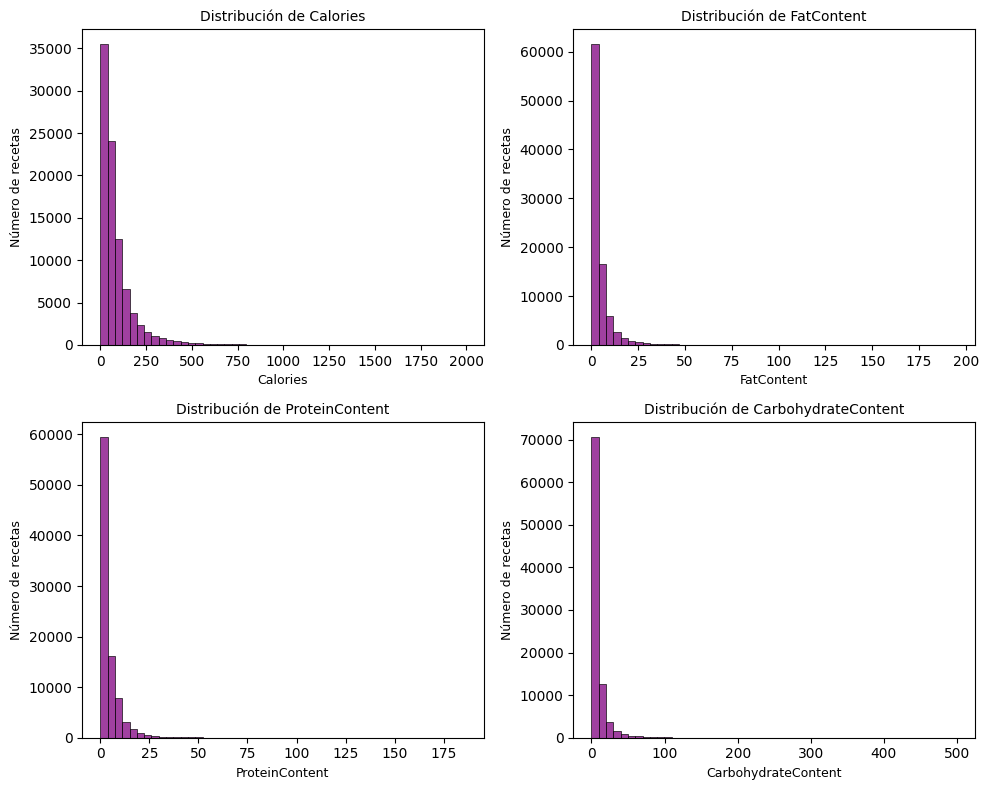

In [ ]:
# Histograma de macronutrientes
nutrients = ["Calories", "FatContent", "ProteinContent", "CarbohydrateContent"]

# Creamos una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Aplanamos la matriz de ejes para iterar fácilmente
axes = axes.flatten()

for i, col in enumerate(nutrients):
    sns.histplot(df[col], bins=50, ax=axes[i], color="purple")

    axes[i].set_title(f"Distribución de {col}", fontsize=10)
    axes[i].set_xlabel(col, fontsize=9)
    axes[i].set_ylabel("Número de recetas", fontsize=9)

plt.tight_layout()
plt.show()

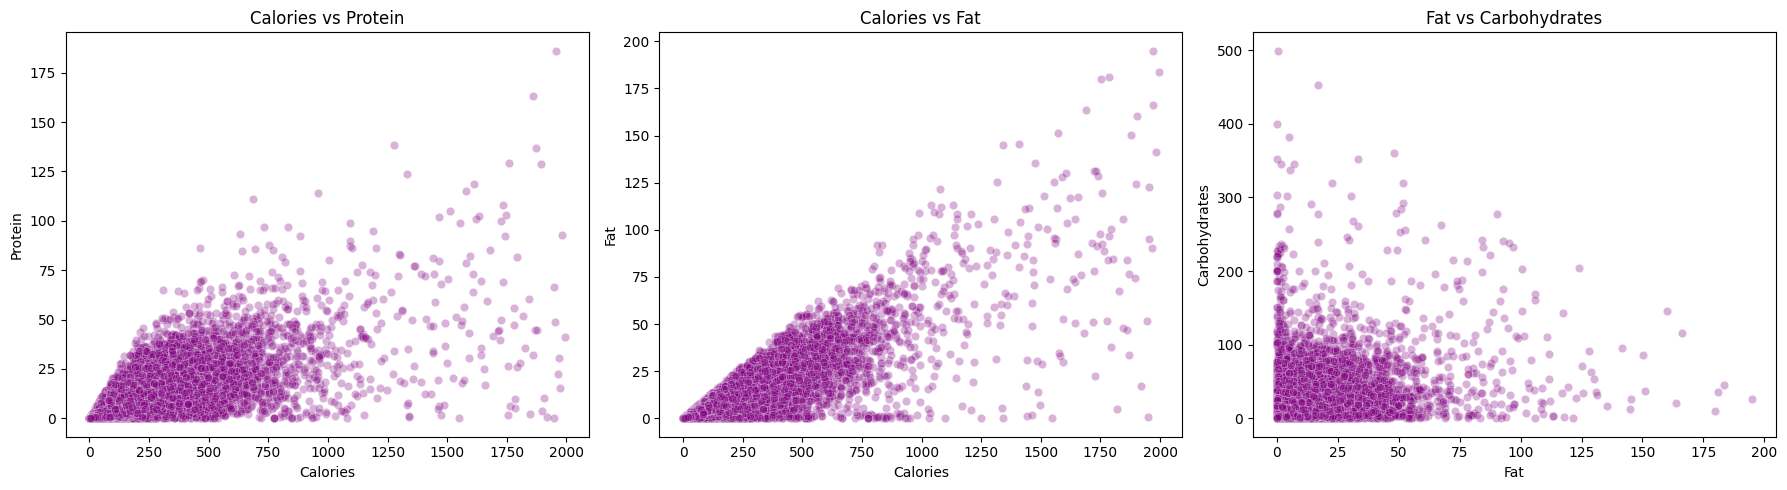

In [ ]:
# Relaciones entre macronutrientes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Calories vs Protein
sns.scatterplot(data=df, x="Calories", y="ProteinContent", alpha=0.3, ax=axes[0], color="purple")
axes[0].set_title("Calories vs Protein")
axes[0].set_xlabel("Calories")
axes[0].set_ylabel("Protein")

# 2. Calories vs Fat
sns.scatterplot(data=df, x="Calories", y="FatContent", alpha=0.3, ax=axes[1], color="purple")
axes[1].set_title("Calories vs Fat")
axes[1].set_xlabel("Calories")
axes[1].set_ylabel("Fat")

# 3. Fat vs Carbohydrates
sns.scatterplot(data=df, x="FatContent", y="CarbohydrateContent", alpha=0.3, ax=axes[2], color="purple")
axes[2].set_title("Fat vs Carbohydrates")
axes[2].set_xlabel("Fat")
axes[2].set_ylabel("Carbohydrates")

# Ajuste fino para que los títulos y etiquetas no se solapen
plt.tight_layout()
plt.show()

/tmp/ipython-input-2011517341.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ingredients_df, y="ingredient", x="count", palette="viridis", legend=False)


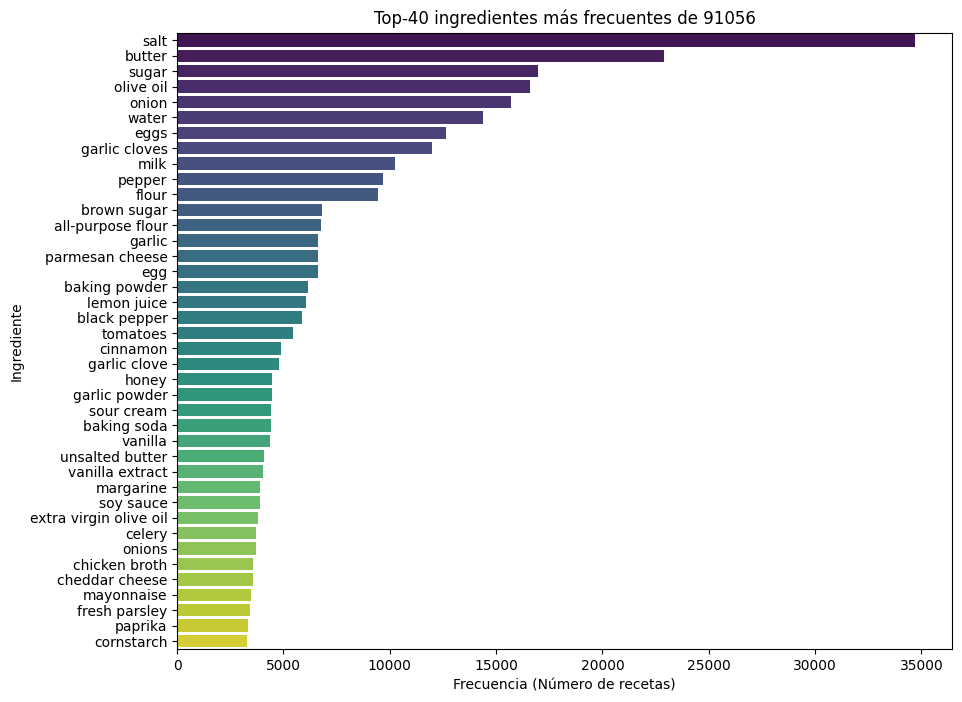

In [ ]:
# 1. Extraemos los ingredientes en forma de listas reales
# Usamos regex para sacar lo que está entre comillas: "harina", "huevo"...
def get_list(text):
    if isinstance(text, str):
        return text.split(", ")
    return []

# Creamos una serie donde cada celda es una lista de ingredientes
all_ingredients_series = df["RecipeIngredientParts"].apply(get_list)

# 2. "Explotamos" las listas y contamos (esta es la alternativa a Counter)
# .explode() convierte cada elemento de la lista en una fila propia
# .value_counts() cuenta cuántas veces aparece cada ingrediente
top_ingredients = all_ingredients_series.explode().value_counts().head(40)

# 3. Convertimos el resultado en un DataFrame para graficar
ingredients_df = top_ingredients.reset_index()
ingredients_df.columns = ["ingredient", "count"]

# 4. Gráfico
plt.figure(figsize=(10, 8))
sns.barplot(data=ingredients_df, y="ingredient", x="count", palette="viridis", legend=False)

plt.title(f"Top-40 ingredientes más frecuentes de {len(all_ingredients_series)}")
plt.xlabel("Frecuencia (Número de recetas)")
plt.ylabel("Ingrediente")
plt.show()

In [ ]:
df.head()

,Name,Images,RecipeIngredientParts,Calories,FatContent,CarbohydrateContent,ProteinContent,RecipeServings,expected_calories,calorie_deviation
0,lowfat berry blue frozen dessert,https://img.sndimg.com/food/image/upload/w_555...,"blueberries, granulated sugar, vanilla yogurt,...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462
1,biryani,https://img.sndimg.com/food/image/upload/w_555...,"saffron, milk, hot green chili peppers, onions...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725
2,best lemonade,https://img.sndimg.com/food/image/upload/w_555...,"sugar, lemons, rind of, lemon, zest of, fresh ...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353
3,carinas tofuvegetable kebabs,https://img.sndimg.com/food/image/upload/w_555...,"extra firm tofu, eggplant, zucchini, mushrooms...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354
4,cabbage soup,https://img.sndimg.com/food/image/upload/w_555...,"plain tomato juice, cabbage, onion, carrots, c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260


In [ ]:
df.shape

(91056, 10)

Tras la limpieza de los campos del dataset, nos quedamos con **91056 registros válidos** para el entrenamiento del modelo.

Almacenamos este dataset limpio para posibles usos futuros.

In [ ]:
df.to_csv("recetas_limpio.csv", index=False)
print("Dataset guardado como recetas_limpio.csv")

Dataset guardado como recetas_limpio.csv


## **7. Preparación del Dataset Limpio para el Entrenamiento del Modelo**

- Normalizamos los nombres de las columnas.

In [ ]:
def normalize_column_names(col):
  """Normaliza los nombres de las columnas de CamelCase a snake_case."""
  col = re.sub(r"(?<!^)(?=[A-Z])", "_", col)
  return col.lower()

In [ ]:
df.columns = [normalize_column_names(col) for col in df.columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91056 entries, 0 to 522509
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     91056 non-null  object 
 1   images                   91056 non-null  object 
 2   recipe_ingredient_parts  91056 non-null  object 
 3   calories                 91056 non-null  float64
 4   fat_content              91056 non-null  float64
 5   carbohydrate_content     91056 non-null  float64
 6   protein_content          91056 non-null  float64
 7   recipe_servings          91056 non-null  float64
 8   expected_calories        91056 non-null  float64
 9   calorie_deviation        91056 non-null  float64
dtypes: float64(7), object(3)
memory usage: 7.6+ MB


In [ ]:
df.head()

,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation
0,lowfat berry blue frozen dessert,https://img.sndimg.com/food/image/upload/w_555...,"blueberries, granulated sugar, vanilla yogurt,...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462
1,biryani,https://img.sndimg.com/food/image/upload/w_555...,"saffron, milk, hot green chili peppers, onions...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725
2,best lemonade,https://img.sndimg.com/food/image/upload/w_555...,"sugar, lemons, rind of, lemon, zest of, fresh ...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353
3,carinas tofuvegetable kebabs,https://img.sndimg.com/food/image/upload/w_555...,"extra firm tofu, eggplant, zucchini, mushrooms...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354
4,cabbage soup,https://img.sndimg.com/food/image/upload/w_555...,"plain tomato juice, cabbage, onion, carrots, c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260


## **8. Ingeniería de Características: Ingredientes y Nutrición**

En esta sección transformaremos los datos crudos de ingredientes y la información nutricional en características más estructuradas y útiles para el modelo. Se realizan los siguientes pasos:

- **Normalización de Ingredientes**: Se limpian y estandarizan los nombres de los ingredientes (por ejemplo, a minúsculas y eliminando acentos o signos de puntuación).

- **Extracción Semántica con WordNet**: Se utiliza WordNet (una base de datos léxica) para inferir categorías de alimentos más generales a partir de los ingredientes (por ejemplo, reconocer 'manzana' como 'fruta', o 'ternera' como 'carne').

- **Inferencia de Tipos de Dieta**: Basándose en las categorías de alimentos y los valores nutricionales (calorías, proteínas, carbohidratos, grasas), se crean nuevas características para clasificar las recetas según tipos de dieta (por ejemplo, 'Vegan', 'Vegetarian', 'High Protein', 'Low Carb', 'Keto', etc.).

### 8.1. Normalización de ingredientes



In [ ]:
def parse_ingredients(raw):
  """Procesa una cadena de ingredientes, los divide por comas, limpia cada uno y devuelve una lista."""
  if not isinstance(raw, str):
      return []

  parts = raw.split(",")

  clean = []
  for p in parts:
      p = p.strip().lower()
      if p:
          clean.append(p)

  return clean

df["ingredients_list"] = df["recipe_ingredient_parts"].apply(parse_ingredients)


In [ ]:
df.head()

,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,ingredients_list
0,lowfat berry blue frozen dessert,https://img.sndimg.com/food/image/upload/w_555...,"blueberries, granulated sugar, vanilla yogurt,...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462,"[blueberries, granulated sugar, vanilla yogurt..."
1,biryani,https://img.sndimg.com/food/image/upload/w_555...,"saffron, milk, hot green chili peppers, onions...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725,"[saffron, milk, hot green chili peppers, onion..."
2,best lemonade,https://img.sndimg.com/food/image/upload/w_555...,"sugar, lemons, rind of, lemon, zest of, fresh ...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353,"[sugar, lemons, rind of, lemon, zest of, fresh..."
3,carinas tofuvegetable kebabs,https://img.sndimg.com/food/image/upload/w_555...,"extra firm tofu, eggplant, zucchini, mushrooms...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354,"[extra firm tofu, eggplant, zucchini, mushroom..."
4,cabbage soup,https://img.sndimg.com/food/image/upload/w_555...,"plain tomato juice, cabbage, onion, carrots, c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260,"[plain tomato juice, cabbage, onion, carrots, ..."


In [ ]:
def normalize_ing(ing):
  """Normaliza una cadena de ingrediente: minúsculas, elimina acentos y caracteres no alfabéticos."""
  ing = ing.lower().strip()
  ing = unicodedata.normalize("NFKD", ing).encode("ascii", "ignore").decode("utf-8")
  ing = re.sub(r"[^a-z\s]", "", ing)
  return ing

df["ingredients_list"] = df["ingredients_list"].apply(
    lambda lst: [normalize_ing(x) for x in lst]
)

In [ ]:
df.head()

,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,ingredients_list
0,lowfat berry blue frozen dessert,https://img.sndimg.com/food/image/upload/w_555...,"blueberries, granulated sugar, vanilla yogurt,...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462,"[blueberries, granulated sugar, vanilla yogurt..."
1,biryani,https://img.sndimg.com/food/image/upload/w_555...,"saffron, milk, hot green chili peppers, onions...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725,"[saffron, milk, hot green chili peppers, onion..."
2,best lemonade,https://img.sndimg.com/food/image/upload/w_555...,"sugar, lemons, rind of, lemon, zest of, fresh ...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353,"[sugar, lemons, rind of, lemon, zest of, fresh..."
3,carinas tofuvegetable kebabs,https://img.sndimg.com/food/image/upload/w_555...,"extra firm tofu, eggplant, zucchini, mushrooms...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354,"[extra firm tofu, eggplant, zucchini, mushroom..."
4,cabbage soup,https://img.sndimg.com/food/image/upload/w_555...,"plain tomato juice, cabbage, onion, carrots, c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260,"[plain tomato juice, cabbage, onion, carrots, ..."


### 8.2. Extracción Semántica con WordNet

In [ ]:
def get_hypernyms(term, max_depth=5):
  """Obtiene los hiperónimos (categorías más generales) de un término usando WordNet hasta una profundidad máxima."""
  synsets = wn.synsets(term, pos=wn.NOUN) # busca conjuntos de sinónimos (synsets)
  hypers = set()
  for s in synsets:
      for path in s.hypernym_paths(): # se obtienen todos los caminos jerárquicos desde el término hasta conceptos más generales
          for node in path[-max_depth:]: # toma solo los últimos 5 niveles del camino (los más generales)
              hypers.add(node.lemma_names()[0].lower()) #extrae el primer nombre del synset en minúsculas y los guarda en un set() para evitar duplicados
  return hypers


### 8.3. Mapeo de Hiperónimos a Categorías Alimenticias


In [ ]:
BASE_CATEGORIES = {
    "fruit": "fruit",
    "vegetable": "vegetable",
    "meat": "meat",
    "fish": "fish",
    "dairy_product": "dairy",
    "milk": "dairy",
    "cheese": "dairy",
    "cereal": "cereal",
    "grain": "cereal",
    "legume": "legume",
    "bean": "legume",
    "pea": "legume",
    "nut": "nut",

    # Mariscos específicas
    "seafood": "fish",
    "shellfish": "fish",
    "crustacean": "fish",
    "shrimp": "fish",
    "prawn": "fish",
    "crab": "fish",
    "lobster": "fish",
    "mussel": "fish",
    "clam": "fish",
    "oyster": "fish",
    "squid": "fish",
    "octopus": "fish",

    # Carnes específicas
    "poultry": "meat",
    "chicken": "meat",
    "beef": "meat",
    "pork": "meat",
    "lamb": "meat",
    "turkey": "meat",
    "duck": "meat",
    "game": "meat",
    "sausage": "meat",
    "bacon": "meat",
    "ham": "meat"
}

OVERRIDES = {
    "quinoa": "cereal",
    "tofu": "legume",
    "tempeh": "legume",

    "shrimp": "fish",
    "prawn": "fish",
    "crab": "fish",
    "lobster": "fish",
    "salmon": "fish",
    "tuna": "fish",
    "cod": "fish",
    "tilapia": "fish",

    "chicken": "meat",
    "beef": "meat",
    "pork": "meat",
    "bacon": "meat",
    "sausage": "meat"
}

In [ ]:
def wordnet_category(term):
  """Clasifica un término (ingrediente) en una categoría alimenticia base usando WordNet."""
  term = term.lower().strip()
  if term in OVERRIDES:
      return OVERRIDES[term]

  hypers = get_hypernyms(term)
  for h in hypers:
      if h in BASE_CATEGORIES:
          return BASE_CATEGORIES[h]
  return None

### 8.4. Inferencia de Tipos de Dieta


In [ ]:
def infer_categories_wordnet(ings):
  """Infiere categorías alimenticias base para una lista de ingredientes usando WordNet."""
  cats = set()
  for ing in ings:
      candidates = [ing] + ing.split()
      for c in candidates:
          cat = wordnet_category(c)
          if cat:
              cats.add(cat)
  return list(cats)

df["base_categories"] = df["ingredients_list"].apply(infer_categories_wordnet)


In [ ]:
df.head()

,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,ingredients_list,base_categories
0,lowfat berry blue frozen dessert,https://img.sndimg.com/food/image/upload/w_555...,"blueberries, granulated sugar, vanilla yogurt,...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462,"[blueberries, granulated sugar, vanilla yogurt...","[fruit, dairy]"
1,biryani,https://img.sndimg.com/food/image/upload/w_555...,"saffron, milk, hot green chili peppers, onions...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725,"[saffron, milk, hot green chili peppers, onion...","[cereal, vegetable, dairy, fruit, meat]"
2,best lemonade,https://img.sndimg.com/food/image/upload/w_555...,"sugar, lemons, rind of, lemon, zest of, fresh ...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353,"[sugar, lemons, rind of, lemon, zest of, fresh...",[fruit]
3,carinas tofuvegetable kebabs,https://img.sndimg.com/food/image/upload/w_555...,"extra firm tofu, eggplant, zucchini, mushrooms...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354,"[extra firm tofu, eggplant, zucchini, mushroom...","[fruit, legume, vegetable]"
4,cabbage soup,https://img.sndimg.com/food/image/upload/w_555...,"plain tomato juice, cabbage, onion, carrots, c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260,"[plain tomato juice, cabbage, onion, carrots, ...",[vegetable]


Definimos los umbrales nutricionales para diferentes componentes como proteínas, fibra, carbohidratos, grasas y calorías. Estos umbrales se usarán para clasificar las recetas en tipos de dieta posteriormente.

In [ ]:
# Umbrales por receta (por ración)
PROTEIN_HIGH = 25     # g
FIBER_HIGH   = 10     # g  (inferida, no calculada directamente)
CARBS_LOW    = 20     # g
CARBS_HIGH   = 60     # g
FAT_HIGH     = 30     # g
CAL_LOW      = 400


Se crean columnas binarias para clasificar las recetas según diversos criterios dietéticos (vegana, vegetariana, alta en proteínas, baja en carbohidratos, etc.), basándose en la presencia de categorías de ingredientes y los umbrales nutricionales definidos.

In [ ]:
# Flags dietéticos básicos (solo los incluidos en base_categories)
df["is_vegan"] = df["base_categories"].apply(
    lambda c: 0 if any(x in c for x in ["meat", "fish", "dairy"]) else 1
)

df["is_vegetarian"] = df["base_categories"].apply(
    lambda c: 0 if any(x in c for x in ["meat", "fish"]) else 1
)

df["has_meat"] = df["base_categories"].apply(lambda c: 1 if "meat" in c else 0)
df["has_fish"] = df["base_categories"].apply(lambda c: 1 if "fish" in c else 0)
df["has_dairy"] = df["base_categories"].apply(lambda c: 1 if "dairy" in c else 0)

In [ ]:
# Validación adicional: campos name + ingredients
# (hay recetas que tienen chicken, fish...pero no lo anuncian en sus ingredientes)

MEAT_KEYWORDS = [
    "chicken", "beef", "pork", "lamb", "turkey", "duck", "bacon",
    "sausage", "ham", "meat", "steak", "pepperoni", "salami",
    "prosciutto", "chorizo", "meatball", "ribs", "brisket", "veal",
    "venison", "goat", "rabbit"
]

FISH_KEYWORDS = [
    "fish", "salmon", "tuna", "cod", "tilapia", "shrimp", "prawn",
    "crab", "lobster", "mussel", "clam", "oyster", "squid", "seafood",
    "shellfish", "calamari", "anchovy", "sardine", "trout", "bass",
    "haddock", "halibut", "mackerel", "snapper", "scallop"
]

DAIRY_KEYWORDS = [
    "milk", "cheese", "butter", "cream", "yogurt", "yoghurt",
    "ghee", "cheddar", "mozzarella", "parmesan", "feta", "brie",
    "ricotta", "gouda", "swiss", "provolone"
]

def check_name_and_ingredients(row):
    """
    Busca keywords de carne/pescado/lácteos en NOMBRE + INGREDIENTES.
    Retorna (has_meat, has_fish, has_dairy).
    """
    # Obtener nombre
    name = str(row.get("name", "")).lower()

    # Obtener ingredientes como texto
    ingredients_list = row.get("ingredients_list", [])
    if isinstance(ingredients_list, list):
        ingredients_str = " ".join([str(ing).lower() for ing in ingredients_list])
    else:
        ingredients_str = ""

    # Combinar nombre + ingredientes
    full_text = name + " " + ingredients_str

    # Buscar keywords
    has_meat = any(keyword in full_text for keyword in MEAT_KEYWORDS)
    has_fish = any(keyword in full_text for keyword in FISH_KEYWORDS)
    has_dairy = any(keyword in full_text for keyword in DAIRY_KEYWORDS)

    return has_meat, has_fish, has_dairy

In [ ]:
# Aplicar validación

# se aplican correcciones por si inicialmente se ha clasificado mal la receta
corrections = {
    "meat": 0,
    "fish": 0,
    "dairy": 0,
    "vegetarian": 0,
    "vegan": 0
}

for idx, row in df.iterrows():
    has_meat_text, has_fish_text, has_dairy_text = check_name_and_ingredients(row)

    # Corregir has_meat
    if has_meat_text and row["has_meat"] == 0:
        df.at[idx, "has_meat"] = 1
        corrections["meat"] += 1

    # Corregir has_fish
    if has_fish_text and row["has_fish"] == 0:
        df.at[idx, "has_fish"] = 1
        corrections["fish"] += 1

    # Corregir has_dairy
    if has_dairy_text and row["has_dairy"] == 0:
        df.at[idx, "has_dairy"] = 1
        corrections["dairy"] += 1

    # Corregir is_vegetarian
    if (has_meat_text or has_fish_text) and row["is_vegetarian"] == 1:
        df.at[idx, "is_vegetarian"] = 0
        corrections["vegetarian"] += 1

    # Corregir is_vegan
    if (has_meat_text or has_fish_text or has_dairy_text) and row["is_vegan"] == 1:
        df.at[idx, "is_vegan"] = 0
        corrections["vegan"] += 1

print(f"\nCorrecciones aplicadas:")
print(f"   - Carne detectada en nombre/ingredientes: {corrections['meat']} recetas")
print(f"   - Pescado detectado en nombre/ingredientes: {corrections['fish']} recetas")
print(f"   - Lácteos detectados en nombre/ingredientes: {corrections['dairy']} recetas")
print(f"   - Vegetarian corregido: {corrections['vegetarian']} recetas")
print(f"   - Vegan corregido: {corrections['vegan']} recetas")


✅ Correcciones aplicadas:
   - Carne detectada en nombre/ingredientes: 6520 recetas
   - Pescado detectado en nombre/ingredientes: 1871 recetas
   - Lácteos detectados en nombre/ingredientes: 1642 recetas
   - Vegetarian corregido: 7788 recetas
   - Vegan corregido: 4840 recetas


In [ ]:
# Aplicamos los flags nutricionales al df

df["high_protein"] = (df["protein_content"] >= PROTEIN_HIGH).astype(int)
df["low_carb"] = (df["carbohydrate_content"] <= CARBS_LOW).astype(int)
df["high_carb"] = (df["carbohydrate_content"] >= CARBS_HIGH).astype(int)
df["high_fat"] = (df["fat_content"] >= FAT_HIGH).astype(int)
df["low_calorie"] = (df["calories"] <= CAL_LOW).astype(int)
df["high_fiber"] = df["base_categories"].apply(
    lambda c: 1 if any(x in c for x in ["fruit", "vegetable", "legume", "cereal"]) else 0
)

In [ ]:
df.head()

,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,...,is_vegetarian,has_meat,has_fish,has_dairy,high_protein,low_carb,high_carb,high_fat,low_calorie,high_fiber
0,lowfat berry blue frozen dessert,https://img.sndimg.com/food/image/upload/w_555...,"blueberries, granulated sugar, vanilla yogurt,...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462,...,1,0,0,1,0,1,0,0,1,1
1,biryani,https://img.sndimg.com/food/image/upload/w_555...,"saffron, milk, hot green chili peppers, onions...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725,...,0,1,0,1,0,1,0,0,1,1
2,best lemonade,https://img.sndimg.com/food/image/upload/w_555...,"sugar, lemons, rind of, lemon, zest of, fresh ...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353,...,1,0,0,0,0,0,0,0,1,1
3,carinas tofuvegetable kebabs,https://img.sndimg.com/food/image/upload/w_555...,"extra firm tofu, eggplant, zucchini, mushrooms...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354,...,1,0,0,0,0,0,0,0,1,1
4,cabbage soup,https://img.sndimg.com/food/image/upload/w_555...,"plain tomato juice, cabbage, onion, carrots, c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260,...,1,0,0,0,0,1,0,0,1,1


In [ ]:
def infer_diet_type(row):
    """
    Infiere etiquetas de tipo de dieta.
    Categorías: Vegan, Vegetarian, High Protein, High Fiber, Keto, High Carb, Low Calorie, Balanced
    """
    labels = []

    # Validación
    has_meat = row.get("has_meat", 0) == 1
    has_fish = row.get("has_fish", 0) == 1
    has_dairy = row.get("has_dairy", 0) == 1

    # 1. ÉTICA ALIMENTARIA
    if row["is_vegan"] == 1 and not (has_meat or has_fish or has_dairy):
        labels.append("Vegan")
    elif row["is_vegetarian"] == 1 and not (has_meat or has_fish):
        labels.append("Vegetarian")

    # 2. PROTEÍNA
    if row["high_protein"] == 1:
        labels.append("High Protein")

    # 3. FIBRA
    if row["high_fiber"] == 1:
        labels.append("High Fiber")

    # 4. CARBOHIDRATOS
    if row["low_carb"] == 1 and row["high_fat"] == 1:
        labels.append("Keto")
    elif row["high_carb"] == 1 and row["low_carb"] == 0:
        labels.append("High Carb")

    # 5. CALORÍAS
    if row["low_calorie"] == 1:
        labels.append("Low Calorie")

    # 6. FALLBACK
    if not labels:
        protein = row.get("protein_content", 0)
        carbs = row.get("carbohydrate_content", 0)
        fat = row.get("fat_content", 0)

        protein_cal = protein * 4
        carbs_cal = carbs * 4
        fat_cal = fat * 9
        total_cal = protein_cal + carbs_cal + fat_cal

        if total_cal > 0:
            protein_pct = protein_cal / total_cal
            carbs_pct = carbs_cal / total_cal
            fat_pct = fat_cal / total_cal

            if protein_pct > 0.35:
                labels.append("High Protein")
            elif carbs_pct > 0.55:
                labels.append("High Carb")
            elif fat_pct > 0.40:
                labels.append("Keto")

        if not labels:
            labels.append("Balanced")

    return ", ".join(sorted(set(labels)))


In [ ]:
# Aplicar la inferencia
df["diet_type"] = df.apply(infer_diet_type, axis=1)


In [ ]:
df[["diet_type"]].head()


,diet_type
0,"High Fiber, Low Calorie, Vegetarian"
1,"High Fiber, Low Calorie"
2,"High Fiber, Low Calorie, Vegan"
3,"High Fiber, Low Calorie, Vegan"
4,"High Fiber, Low Calorie, Vegan"


In [ ]:
df.head()

,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,...,has_meat,has_fish,has_dairy,high_protein,low_carb,high_carb,high_fat,low_calorie,high_fiber,diet_type
0,lowfat berry blue frozen dessert,https://img.sndimg.com/food/image/upload/w_555...,"blueberries, granulated sugar, vanilla yogurt,...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462,...,0,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegetarian"
1,biryani,https://img.sndimg.com/food/image/upload/w_555...,"saffron, milk, hot green chili peppers, onions...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725,...,1,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie"
2,best lemonade,https://img.sndimg.com/food/image/upload/w_555...,"sugar, lemons, rind of, lemon, zest of, fresh ...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353,...,0,0,0,0,0,0,0,1,1,"High Fiber, Low Calorie, Vegan"
3,carinas tofuvegetable kebabs,https://img.sndimg.com/food/image/upload/w_555...,"extra firm tofu, eggplant, zucchini, mushrooms...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354,...,0,0,0,0,0,0,0,1,1,"High Fiber, Low Calorie, Vegan"
4,cabbage soup,https://img.sndimg.com/food/image/upload/w_555...,"plain tomato juice, cabbage, onion, carrots, c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260,...,0,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegan"


Visualización de la distribución de los tipos de dietas.

/tmp/ipython-input-1039720338.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=diet_df, x="diet_type", y="calories", palette="viridis")


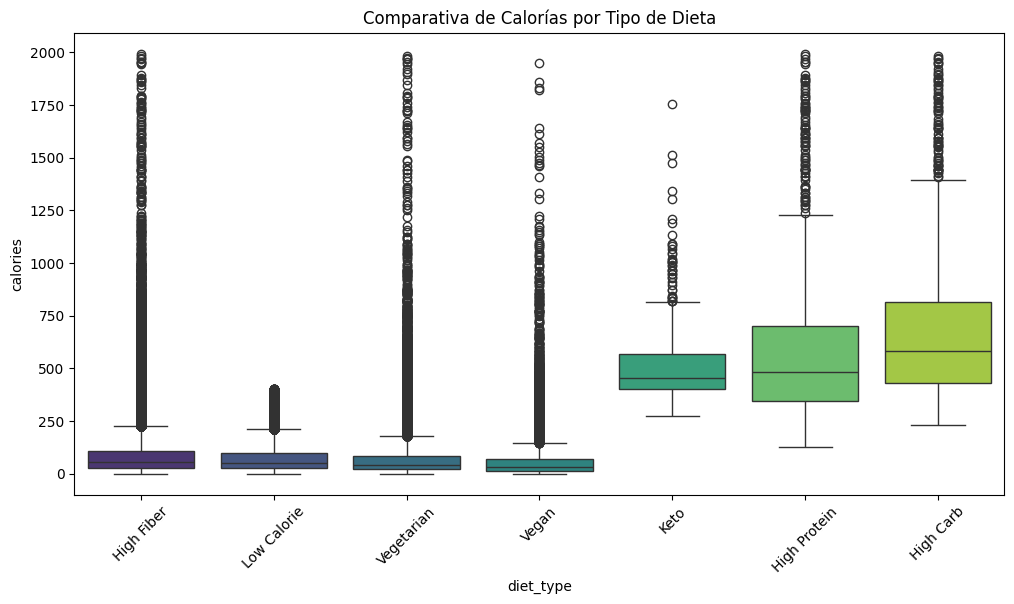

In [ ]:
diet_tags =  df["diet_type"].str.split(", ").explode().unique()
diet_data = []

for diet in diet_tags:
    mask = df["diet_type"].str.contains(diet, case=False, na=False)

    subset = df[mask].copy()

    subset["diet_type"] = diet
    diet_data.append(subset)

# 3. Concatenamos todo en un nuevo DataFrame
diet_df = pd.concat(diet_data, ignore_index=True)


plt.figure(figsize=(12, 6))
# Comparar calorías por tipo de dieta
sns.boxplot(data=diet_df, x="diet_type", y="calories", palette="viridis")
plt.title("Comparativa de Calorías por Tipo de Dieta")
plt.xticks(rotation=45)
plt.show()

## **9. Separación y Entrenamiento de los Datos**

### 9.1. Definición del Target (Variable Objetivo) y Codificación Multi-Etiqueta

El target es `diet_type`, que contiene múltiples etiquetas para cada receta.
Se transforma a un formato binario multi-etiqueta usando MultiLabelBinarizer.

In [ ]:
y = df["diet_type"].dropna().str.split(", ")

mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)

print("Etiquetas de dieta:", mlb.classes_)

# Nos aseguramos de que el DataFrame para el modelo solo contenga filas con targets válidos.
df_model = df.loc[y.index].copy()

Etiquetas de dieta: ['High Carb' 'High Fiber' 'High Protein' 'Keto' 'Low Calorie' 'Vegan'
 'Vegetarian']


### 9.2. Selección y Preparación de Features (Variables Predictoras)

Se combinan las columnas de texto (nombre e ingredientes normalizados) y se seleccionan las columnas numéricas y booleanas que se usarán como features.

In [ ]:
# Feature de texto: concatenación del nombre y los ingredientes normalizados.
df_model["ingredients_text"] = (
    df_model["name"].fillna('') + ' ' +
    df_model["ingredients_list"].apply(
      lambda x: ' '.join(x) if isinstance(x, list) else ''
    )
)

# Columnas numéricas: información nutricional por porción.
num_cols = [
    "calories",
    "fat_content",
    "carbohydrate_content",
    "protein_content"
]

# Columnas booleanas: flags de tipo de dieta inferidos.
bool_cols = [
    "has_meat","has_fish","has_dairy",
    "high_protein","low_carb","high_carb",
    "high_fat","low_calorie","high_fiber"
]

# Se construye el DataFrame final de features.
feature_cols = ["ingredients_text"] + num_cols + bool_cols
X = df_model[feature_cols].copy()

In [ ]:
# Verificar que no hay NaN en features numéricas
X[num_cols] = X[num_cols].fillna(0)
X[bool_cols] = X[bool_cols].fillna(0).astype(int)

print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y_encoded.shape}")
print(f"NaN en X: {X.isna().sum().sum()}")


Shape de X: (91056, 14)
Shape de y: (91056, 7)
NaN en X: 0


### 9.3. Configuración del Preprocesador de Features

Se utiliza ColumnTransformer para aplicar diferentes transformaciones a distintos tipos de features:
 - TF-IDF para el texto de ingredientes.
 - Estandarización para las características numéricas.
 - Las características booleanas se pasan directamente.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.8,             # ignora términos muy frecuentes
            strip_accents='unicode' # Normaliza caracteres
        ), "ingredients_text"),     # aplicamos TF-IDF a los ingredientes

        ("num", StandardScaler(), num_cols),  # Escala las características numéricas
        ("bool", "passthrough", bool_cols)    # Pasa las booleanas sin cambios
    ]
)

### 9.4. Definición y Configuración del Modelo de Clasificación

Se define un clasificador multi-etiqueta usando OneVsRestClassifier con un modelo de Regresión Logística.

In [ ]:
classifier = OneVsRestClassifier(
    LogisticRegression(
        max_iter=2000,
        class_weight="balanced", # Ajustar pesos para clases desbalanceadas
        solver="lbfgs"           # Algoritmo de optimización para problemas multiclase
    ),
    n_jobs=-1 # Usar todos los núcleos disponibles para el entrenamiento
)

# Se crea un Pipeline que encadena el preprocesamiento y el clasificador.
pipe = Pipeline([
    ("prep", preprocessor), # Paso de preprocesamiento
    ("clf", classifier)     # Paso de clasificación
])

### 9.5. División de Datos y Entrenamiento del Modelo

Los datos se dividen en conjuntos de entrenamiento y prueba. El modelo se entrena con los datos de entrenamiento.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2, # 80% entrenamiento, 20% prueba
    random_state=42
)

# Entrenamiento del pipeline (preprocesamiento + modelo).
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.8,
                                                                  max_features=5000,
                                                                  min_df=3,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  strip_accents='unicode'),
                                                  'ingredients_text'),
                                                 ('num', StandardScaler(),
                                                  ['calories', 'fat_content',
                                                   'carbohydrate_content',
                                                   'protein_content']),
                                                 ('bool', 'passthrough',
                                                  ['has_meat', 'has_fish',
                                                   'has_dairy', 'high_protein',
                                                   'low_carb', 'high_carb',
                                                   'high_fat', 'low_calorie',
                                                   'high_fiber'])])),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=2000),
                                     n_jobs=-1))])

### 9.6. Evaluación del Modelo

Se realizan predicciones sobre el conjunto de prueba y se genera un reporte de clasificación para evaluar el rendimiento.

In [ ]:
y_pred = pipe.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred,
        target_names=mlb.classes_,  # Nombres de las clases para el reporte
        zero_division=0             # Evitar división por cero
    )
)

              precision    recall  f1-score   support

   High Carb       1.00      1.00      1.00       213
  High Fiber       1.00      1.00      1.00     16004
High Protein       1.00      1.00      1.00       274
        Keto       0.60      0.97      0.74        89
 Low Calorie       1.00      1.00      1.00     17797
       Vegan       1.00      1.00      1.00      3538
  Vegetarian       1.00      1.00      1.00      6551

   micro avg       1.00      1.00      1.00     44466
   macro avg       0.94      1.00      0.96     44466
weighted avg       1.00      1.00      1.00     44466
 samples avg       1.00      1.00      1.00     44466



### 9.7. Ejemplo de Predicción

In [ ]:
# Ejemplo de predicción simplificado para una sola receta
print("\n" + "=" * 70)
print(f"{'Receta':<30} {'Real':<20} {'Predicho':<20}")
print("=" * 70)

# Tomamos la primera receta del conjunto de prueba
sample_index = X_test.index[0]
recipe_name = df_model.loc[sample_index, "name"]

# Realizamos la predicción
predicted_labels_encoded = pipe.predict(X_test.iloc[0:1])

# Decodificamos las etiquetas
real_labels = ", ".join(mlb.inverse_transform(y_test[0:1])[0])
pred_labels = ", ".join(mlb.inverse_transform(predicted_labels_encoded)[0])

print(f"{recipe_name[:28]:<30} {real_labels[:18]:<20} {pred_labels[:18]:<20}")
print("=" * 70)


Receta                         Real                 Predicho            
mango salsa fish tacos         High Fiber, Low Ca   High Fiber, Low Ca  


## **10. Asignación de Etiquetas de Tipo de Comida**

### 10.1. Aplicación y Análisis de Etiquetas de Comida

In [ ]:
def assign_meal_labels(row):
    """
    Clasifica recetas en tipos de comida usando nombre + contexto nutricional.
    Categorías: Breakfast, Lunch, Dinner, Snack
    """
    name = row["name"].lower() if isinstance(row["name"], str) else ""
    labels = []

    # Obtener contexto nutricional
    calories = row.get("calories", 0)

    # Desayuno
    breakfast_keywords = [
        "pancake", "waffle", "omelette", "omelet", "oatmeal",
        "cereal", "toast", "breakfast", "morning", "brunch",
        "french toast", "scrambled egg", "fried egg", "bagel",
        "granola", "muesli", "porridge", "crepe"
    ]
    if any(k in name for k in breakfast_keywords):
        labels.append("Breakfast")

    # Snack (incluye merienda)
    snack_keywords = [
        "cookie", "cookies", "bar", "muffin", "snack",
        "smoothie", "shake", "bite", "ball", "chip",
        "cracker", "popcorn", "trail mix", "energy bar",
        "protein bar", "granola bar", "brownie"
    ]
    if any(k in name for k in snack_keywords):
        labels.append("Snack")

    # Almuerzo y Cena
    main_dish_keywords = [
        "biryani", "curry", "stew", "roast", "lasagna",
        "casserole", "pot pie", "shepherd's pie",
        "risotto", "paella", "goulash", "tagine"
    ]

    protein_keywords = [
        "grilled chicken", "roasted chicken", "fried chicken",
        "baked chicken", "chicken breast", "chicken thigh",
        "beef steak", "ground beef", "beef roast",
        "pork chop", "pork roast", "pork loin",
        "salmon", "tuna", "cod", "tilapia", "shrimp",
        "lamb", "duck", "turkey"
    ]

    carb_base_keywords = [
        "pasta", "spaghetti", "linguine", "penne", "fettuccine",
        "noodles", "rice bowl", "fried rice", "pilaf",
        "burrito", "taco", "quesadilla", "enchilada",
        "pizza", "sandwich", "burger", "wrap"
    ]

    # Verificar si es plato principal
    is_main_dish = (
        any(k in name for k in main_dish_keywords) or
        any(k in name for k in protein_keywords) or
        any(k in name for k in carb_base_keywords)
    )

    if is_main_dish:
        # Si ya tiene Breakfast, no añadir Lunch/Dinner
        if "Breakfast" not in labels:
            if calories > 500:
                labels.extend(["Lunch", "Dinner"])
            elif calories > 300:
                labels.append("Lunch")
            else:
                labels.extend(["Lunch", "Dinner"])

    # Sopas y Ensaladas
    if any(k in name for k in ["soup", "salad", "bowl"]):
        if "Breakfast" not in labels:
            if calories > 400:
                labels.extend(["Lunch", "Dinner"])
            elif calories > 200:
                labels.append("Lunch")
            else:
                labels.append("Snack")

    # Fallback si no se cumple ninguna de las condiciones anteriores
    if not labels:
        if calories > 0:
            if calories < 200:
                labels.append("Snack")
            elif calories < 400:
                labels.append("Lunch")
            else:
                labels.extend(["Lunch", "Dinner"])
        else:
            labels.append("Lunch")

    return sorted(list(set(labels)))

In [ ]:
# Aplicamos la función `assign_meal_labels` a cada receta del DataFrame.
df["meal_type"] = df.apply(assign_meal_labels, axis=1)

In [ ]:
df.head()

,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,...,has_fish,has_dairy,high_protein,low_carb,high_carb,high_fat,low_calorie,high_fiber,diet_type,meal_type
0,lowfat berry blue frozen dessert,https://img.sndimg.com/food/image/upload/w_555...,"blueberries, granulated sugar, vanilla yogurt,...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegetarian",[Snack]
1,biryani,https://img.sndimg.com/food/image/upload/w_555...,"saffron, milk, hot green chili peppers, onions...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie","[Dinner, Lunch]"
2,best lemonade,https://img.sndimg.com/food/image/upload/w_555...,"sugar, lemons, rind of, lemon, zest of, fresh ...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353,...,0,0,0,0,0,0,1,1,"High Fiber, Low Calorie, Vegan",[Snack]
3,carinas tofuvegetable kebabs,https://img.sndimg.com/food/image/upload/w_555...,"extra firm tofu, eggplant, zucchini, mushrooms...",268.05,12.00,32.10,14.65,2.0,590.0,0.100354,...,0,0,0,0,0,0,1,1,"High Fiber, Low Calorie, Vegan",[Lunch]
4,cabbage soup,https://img.sndimg.com/food/image/upload/w_555...,"plain tomato juice, cabbage, onion, carrots, c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260,...,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegan",[Snack]


In [ ]:
# Análisis de distribución
print("=" * 60)
print("DISTRIBUCIÓN DE MEAL TYPES")
print("=" * 60)

meal_counter = Counter(tuple(sorted(x)) for x in df["meal_type"])
for meal_combo, count in meal_counter.most_common(15):
    pct = (count / len(df)) * 100
    print(f"{str(meal_combo):40s}: {count:5d} ({pct:5.1f}%)")

DISTRIBUCIÓN DE MEAL TYPES
('Snack',)                              : 60548 ( 66.5%)
('Dinner', 'Lunch')                     : 20127 ( 22.1%)
('Lunch',)                              :  4031 (  4.4%)
('Breakfast',)                          :  3710 (  4.1%)
('Dinner', 'Lunch', 'Snack')            :  2101 (  2.3%)
('Breakfast', 'Snack')                  :   509 (  0.6%)
('Lunch', 'Snack')                      :    30 (  0.0%)


Visualización de la distribución del campo `meal_type`.

/tmp/ipython-input-1999947116.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meal_df, x="meal_type_label", y="calories", palette="viridis")


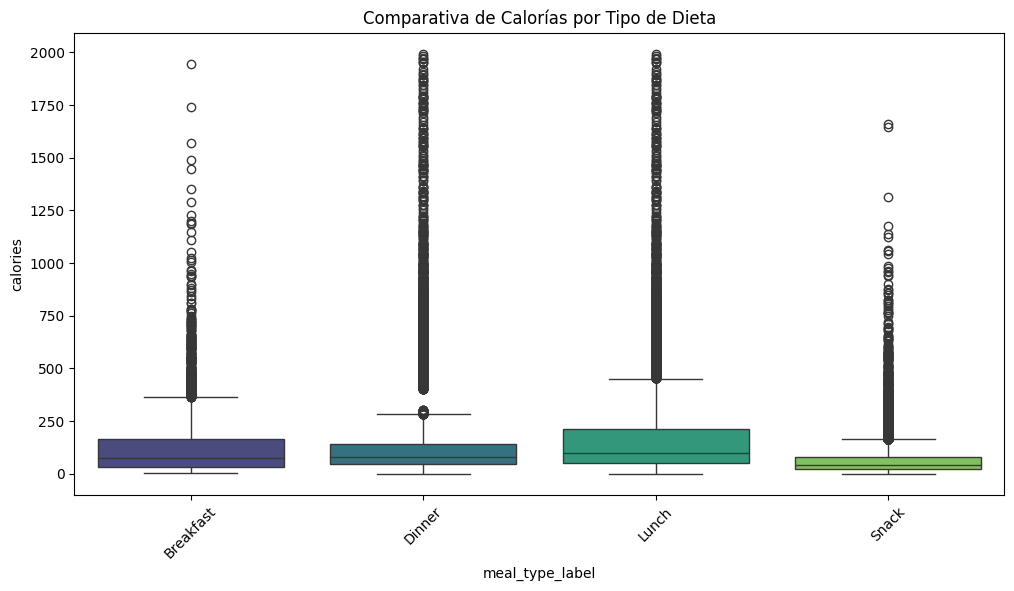

In [ ]:
meal_tags = ["Breakfast", "Dinner", "Lunch", "Snack"]

meal_data = []

for meal in meal_tags:
    mask = df["meal_type"].apply(lambda x: meal in x)

    subset = df[mask].copy()

    subset["meal_type_label"] = meal
    meal_data.append(subset)

meal_df = pd.concat(meal_data, ignore_index=True)

plt.figure(figsize=(12, 6))
# Comparar calorías por tipo de dieta
sns.boxplot(data=meal_df, x="meal_type_label", y="calories", palette="viridis")
plt.title("Comparativa de Calorías por Tipo de Dieta")
plt.xticks(rotation=45)
plt.show()

### 10.2. Preparación y Entrenamiento del Clasificador de Tipo de Comida

In [ ]:
# Preparación
df_meal_model = df.copy()

# Feature de texto: nombre + ingredientes
df_meal_model["meal_text"] = (
    df_meal_model["name"].fillna('') + ' ' +
    df_meal_model["ingredients_list"].apply(
        lambda x: ' '.join(x[:10]) if isinstance(x, list) else ''
    )
)

# Features numéricas
meal_num_cols = ["calories", "fat_content", "protein_content", "carbohydrate_content"]
meal_num_cols = [col for col in meal_num_cols if col in df_meal_model.columns]

# Features booleanas
meal_bool_cols = ["high_protein", "high_carb", "low_calorie", "high_fiber", "high_fat", "low_carb"]
meal_bool_cols = [col for col in meal_bool_cols if col in df_meal_model.columns]

In [ ]:
# Definimos el preprocesador
meal_preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            ngram_range=(1, 3),
            min_df=2,
            max_df=0.7,
            max_features=3000
        ), "meal_text"),
        ("num", StandardScaler(), meal_num_cols),
        ("bool", "passthrough", meal_bool_cols)
    ]
)

# Crear la X
meal_features = ["meal_text"] + meal_num_cols + meal_bool_cols
X_meal = df_meal_model[meal_features].copy()

# Rellenar campos NaN
X_meal[meal_num_cols] = X_meal[meal_num_cols].fillna(0)
if meal_bool_cols:
    X_meal[meal_bool_cols] = X_meal[meal_bool_cols].fillna(0).astype(int)


In [ ]:
# Definimos la Target
mlb_meal = MultiLabelBinarizer()
y_meal = mlb_meal.fit_transform(df["meal_type"])

In [ ]:
# Distribución de los tipos de comida
print("\n" + "=" * 60)
print("MEAL CLASSES:")
print("=" * 60)
for i, label in enumerate(mlb_meal.classes_):
    count = y_meal[:, i].sum()
    pct = (count / len(y_meal)) * 100
    print(f"{label:15s}: {count:5d} recetas ({pct:5.1f}%)")


MEAL CLASSES:
Breakfast      :  4219 recetas (  4.6%)
Dinner         : 22228 recetas ( 24.4%)
Lunch          : 26289 recetas ( 28.9%)
Snack          : 63188 recetas ( 69.4%)


In [ ]:
# Separamos los datos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X_meal, y_meal,
    test_size=0.2,
    random_state=42
)


Creamos una *pipeline* que vectoriza los nombres de las recetas usando TF-IDF y luego aplica un clasificador de regresión logística para manejar múltiples etiquetas de comida. Y finalmente,entrenamos este modelo con los datos de entrenamiento, se hacen predicciones sobre los datos de prueba y se muestra un informe detallado de su rendimiento

In [ ]:
# Definimos la Pipeline
meal_pipe = Pipeline([
    ("prep", meal_preprocessor),
    ("clf", OneVsRestClassifier(
        LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            solver='lbfgs',
            random_state=42
        ),
        n_jobs=-1
    ))
])

In [ ]:
# Entrenamiento
meal_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.7,
                                                                  max_features=3000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'meal_text'),
                                                 ('num', StandardScaler(),
                                                  ['calories', 'fat_content',
                                                   'protein_content',
                                                   'carbohydrate_content']),
                                                 ('bool', 'passthrough',
                                                  ['high_protein', 'high_carb',
                                                   'low_calorie', 'high_fiber',
                                                   'high_fat', 'low_carb'])])),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=2000,
                                                                  random_state=42),
                                     n_jobs=-1))])

In [ ]:
# Predicción
y_pred = meal_pipe.predict(X_test)

In [ ]:
# Mostramos el informe de evaluación
print(
    classification_report(
        y_test,
        y_pred,
        target_names=mlb_meal.classes_
    )
)

              precision    recall  f1-score   support

   Breakfast       0.58      0.89      0.70       875
      Dinner       0.84      0.93      0.89      4386
       Lunch       0.85      0.93      0.89      5215
       Snack       0.96      0.93      0.94     12651

   micro avg       0.89      0.93      0.91     23127
   macro avg       0.81      0.92      0.85     23127
weighted avg       0.90      0.93      0.91     23127
 samples avg       0.91      0.93      0.91     23127



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 10.3. Evaluación y Ejemplos de Predicción del Modelo de Tipo de Comida

In [ ]:
# Ejemplo de predicción
dish_name = "Grilled chicken with rice and vegetables"

# Get the numerical and boolean columns expected by the preprocessor
meal_num_cols = ["calories", "fat_content", "protein_content", "carbohydrate_content"]
meal_bool_cols = ["high_protein", "high_carb", "low_calorie", "high_fiber", "high_fat", "low_carb"]

# Create a dictionary with all required columns and default values
new_dish_data = {
    "meal_text": [dish_name],
}
for col in meal_num_cols:
    new_dish_data[col] = [0.0]  # Use 0.0 for numerical features
for col in meal_bool_cols:
    new_dish_data[col] = [0]    # Use 0 for boolean features

# Create a DataFrame for the single dish
test_dish_df = pd.DataFrame(new_dish_data)

pred = meal_pipe.predict(test_dish_df)
print(mlb_meal.inverse_transform(pred))


[('Dinner', 'Lunch')]


In [ ]:
# Evaluación del modelo predictivo
probas = meal_pipe.predict_proba(test_dish_df)[0]

for label, p in zip(mlb_meal.classes_, probas):
    print(f"{label}: {p:.2f}")

Breakfast: 0.01
Dinner: 1.00
Lunch: 0.78
Snack: 0.27


Comprobamos si las recetas han sido clasificadas exactamente como `Lunch`, `Cena`, `Snack` o `Breakfast`.

In [ ]:
df[
    df["meal_type"].apply(lambda x: set(x) == {"Lunch", "Dinner"})
]


,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,...,has_fish,has_dairy,high_protein,low_carb,high_carb,high_fat,low_calorie,high_fiber,diet_type,meal_type
1,biryani,https://img.sndimg.com/food/image/upload/w_555...,"saffron, milk, hot green chili peppers, onions...",185.12,9.80,14.07,10.57,6.0,1120.4,0.008725,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie","[Dinner, Lunch]"
6,warm chicken a la king,https://img.sndimg.com/food/image/upload/w_555...,"chicken, butter, flour, milk, celery, button m...",447.75,33.40,14.55,22.65,2.0,898.8,0.003681,...,0,1,0,1,0,1,0,1,"High Fiber, Keto","[Dinner, Lunch]"
20,lowfat burgundy beef vegetable stew,https://img.sndimg.com/food/image/upload/w_555...,"beef eye round, dried thyme leaves, salt, pepp...",46.68,1.00,3.73,4.97,6.0,262.8,0.061544,...,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie","[Dinner, Lunch]"
62,cheeseburger casserole,https://img.sndimg.com/food/image/upload/w_555...,"flour, ground beef, onion, tomato sauce, ketch...",90.58,4.87,7.47,4.25,6.0,544.0,0.000918,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie","[Dinner, Lunch]"
66,butterflied lamb with garlic butter,https://img.sndimg.com/food/image/upload/w_555...,"lamb, parsley, fresh thyme, lemon, rind of, ga...",298.65,18.70,13.18,18.98,4.0,1187.6,0.005855,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie","[Dinner, Lunch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522449,pasta with sausage and fennel fronds,https://img.sndimg.com/food/image/upload/w_555...,"olive oil, hot Italian sausage, garlic cloves,...",256.38,13.42,22.55,11.05,4.0,1020.9,0.004481,...,0,1,0,0,0,0,1,1,"High Fiber, Low Calorie","[Dinner, Lunch]"
522474,pad thai noodles,https://img.sndimg.com/food/image/upload/w_555...,"fish sauce, tamarind paste, lime juice, low so...",561.15,27.50,57.80,21.45,2.0,1129.0,0.005965,...,1,0,0,0,0,0,0,1,High Fiber,"[Dinner, Lunch]"
522487,chicken pot pie with mashed potato crust,https://img.sndimg.com/food/image/upload/w_555...,"potatoes, milk, poultry seasoning, butter, sal...",110.28,5.88,12.50,2.55,4.0,452.3,0.025334,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie","[Dinner, Lunch]"
522488,spicy smoky roast chicken,https://img.sndimg.com/food/image/upload/w_555...,"barbecue sauce, black vinegar, oregano, rice w...",143.38,9.50,1.82,11.78,4.0,559.6,0.024195,...,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie","[Dinner, Lunch]"


In [ ]:
df[
    df["meal_type"].apply(lambda x: set(x) == {"Snack"})
]

,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,...,has_fish,has_dairy,high_protein,low_carb,high_carb,high_fat,low_calorie,high_fiber,diet_type,meal_type
0,lowfat berry blue frozen dessert,https://img.sndimg.com/food/image/upload/w_555...,"blueberries, granulated sugar, vanilla yogurt,...",42.72,0.62,9.28,0.80,4.0,183.7,0.074462,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegetarian",[Snack]
2,best lemonade,https://img.sndimg.com/food/image/upload/w_555...,"sugar, lemons, rind of, lemon, zest of, fresh ...",77.78,0.05,20.38,0.08,4.0,329.0,0.057353,...,0,0,0,0,0,0,1,1,"High Fiber, Low Calorie, Vegan",[Snack]
4,cabbage soup,https://img.sndimg.com/food/image/upload/w_555...,"plain tomato juice, cabbage, onion, carrots, c...",25.90,0.10,6.28,1.08,4.0,121.2,0.168260,...,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegan",[Snack]
7,buttermilk pie with gingersnap crumb crust,https://img.sndimg.com/food/image/upload/w_555...,"sugar, margarine, egg, flour, salt, buttermilk...",28.50,0.89,4.69,0.52,8.0,230.7,0.011790,...,0,1,0,1,0,0,1,0,Low Calorie,[Snack]
14,cafe cappuccino,https://img.sndimg.com/food/image/upload/w_555...,"instant coffee, sugar, nonfat dry milk solid",3.46,0.01,0.71,0.15,18.0,62.9,0.011076,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegetarian",[Snack]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522469,creamy french eggs,https://img.sndimg.com/food/image/upload/w_555...,"eggs, Dijon mustard, heavy cream, sea salt, bl...",160.80,11.65,7.40,6.70,2.0,322.5,0.002790,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegetarian",[Snack]
522479,grandmas chocolate dumplings,https://img.sndimg.com/food/image/upload/w_555...,"brown sugar, cornstarch, salt, vanilla, water,...",83.95,2.10,15.67,0.90,6.0,511.0,0.014464,...,0,1,0,1,0,0,1,0,"Low Calorie, Vegetarian",[Snack]
522481,chimichurri grilling rub,https://img.sndimg.com/food/image/upload/w_555...,"black pepper, paprika, garlic powder, kosher s...",1.16,0.02,0.25,0.06,20.0,27.6,0.186722,...,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegan",[Snack]
522486,jewishstyle braised beef brisket,https://img.sndimg.com/food/image/upload/w_555...,"salt, pepper, beef brisket, yellow onions, car...",82.46,3.60,2.33,9.09,8.0,624.4,0.053428,...,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie",[Snack]


In [ ]:
df[
    df["meal_type"].apply(lambda x: set(x) == {"Breakfast"})
]

,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,...,has_fish,has_dairy,high_protein,low_carb,high_carb,high_fat,low_calorie,high_fiber,diet_type,meal_type
223,spanish potato omelet tortilla a la espanola,https://img.sndimg.com/food/image/upload/w_555...,"olive oil, potatoes, onion, coarse salt, eggs",212.00,14.78,17.08,3.55,4.0,861.9,0.016372,...,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegan",[Breakfast]
382,basic crepes ii,https://img.sndimg.com/food/image/upload/w_555...,"eggs, flour, milk, butter, salt",10.01,0.45,1.10,0.36,10.0,98.9,0.011869,...,0,1,0,1,0,0,1,0,"Low Calorie, Vegetarian",[Breakfast]
773,breakfast pizza ii,https://img.sndimg.com/food/image/upload/w_555...,"eggs, bacon, cheddar cheese",101.65,7.92,3.47,3.88,6.0,603.9,0.009822,...,0,1,0,1,0,0,1,0,Low Calorie,[Breakfast]
816,oatmeal pancakes,https://img.sndimg.com/food/image/upload/w_555...,"oatmeal, buttermilk, eggs, flour, sugar, bakin...",1053.30,22.50,157.50,54.70,1.0,1051.3,0.001897,...,0,1,1,0,1,0,0,0,"High Carb, High Protein, Vegetarian",[Breakfast]
896,mc donalds pancakes,https://img.sndimg.com/food/image/upload/w_555...,"egg, sugar, biscuit mix",45.12,1.92,6.04,0.86,5.0,224.4,0.005296,...,0,0,0,1,0,0,1,0,"Low Calorie, Vegan",[Breakfast]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522151,masala omelette,https://img.sndimg.com/food/image/upload/w_555...,"eggs, red onions, yellow onions, chili powder,...",85.25,6.72,2.85,3.50,4.0,343.7,0.007895,...,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegan",[Breakfast]
522304,sweet potato waffles with cinnamon maple syrup,https://img.sndimg.com/food/image/upload/w_555...,"sweet potato, dark brown sugar, milk, butter, ...",266.02,5.10,52.68,3.55,4.0,1083.2,0.017933,...,0,1,0,0,0,0,1,1,"High Fiber, Low Calorie, Vegetarian",[Breakfast]
522388,cheese omelet in a mug minutes recipe,https://img.sndimg.com/food/image/upload/w_555...,"egg, green bell pepper, cheese, onion, tomatoe...",125.40,8.20,3.30,9.30,1.0,124.2,0.009494,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegetarian",[Breakfast]
522450,gluten free apple fritter pancakes,https://img.sndimg.com/food/image/upload/w_555...,"baking powder, baking soda, salt, cinnamon, eg...",86.48,2.62,13.82,2.58,4.0,356.9,0.031709,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegetarian",[Breakfast]


Mostramos la frecuencia de cada combinación única de tipos de comida presentes en la columna `meal_type` del DataFrame,

In [ ]:
Counter(tuple(x) for x in df["meal_type"])


Counter({('Snack',): 60548,
         ('Dinner', 'Lunch'): 20127,
         ('Lunch',): 4031,
         ('Dinner', 'Lunch', 'Snack'): 2101,
         ('Breakfast',): 3710,
         ('Breakfast', 'Snack'): 509,
         ('Lunch', 'Snack'): 30})

## **11. Modelo de Recomendación Basado en Características Nutricionales (KNN)**

### 11.1. Exploración y Preparación de Datos para KNN

In [ ]:
df.describe()

,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,is_vegan,is_vegetarian,has_meat,has_fish,has_dairy,high_protein,low_carb,high_carb,high_fat,low_calorie,high_fiber
count,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000,91056.000000
mean,88.617069,4.384815,8.215421,4.140290,6.613952,347.155217,0.036878,0.190817,0.550672,0.395515,0.093239,0.607439,0.015913,0.914866,0.011960,0.013969,0.975279,0.875725
std,121.855104,7.391690,14.456043,6.441119,4.673712,252.398738,0.051348,0.392947,0.497428,0.488964,0.290769,0.488323,0.125141,0.279083,0.108705,0.117365,0.155275,0.329897
min,0.010000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.030000,0.820000,1.880000,0.520000,4.000000,173.700000,0.009718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,53.650000,2.220000,4.250000,1.830000,6.000000,291.400000,0.021288,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,104.850000,5.010000,9.130000,5.600000,8.000000,452.700000,0.043998,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1993.800000,195.000000,499.300000,186.100000,24.000000,2097.200000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.sort_values(by="calories", ascending=False)


,name,images,recipe_ingredient_parts,calories,fat_content,carbohydrate_content,protein_content,recipe_servings,expected_calories,calorie_deviation,...,has_fish,has_dairy,high_protein,low_carb,high_carb,high_fat,low_calorie,high_fiber,diet_type,meal_type
161435,solo simple spicy stroganoff,https://img.sndimg.com/food/image/upload/w_555...,"beef, onion, cheddar cheese, tomatoes, salt, b...",1993.80,183.6,44.80,41.0,1.0,1995.6,0.000902,...,0,1,1,0,0,1,0,1,"High Fiber, High Protein","[Dinner, Lunch]"
6728,crock pot bean dip,https://img.sndimg.com/food/image/upload/w_555...,"monterey jack cheese, cheddar cheese, sour cre...",1982.60,141.5,96.00,92.6,1.0,2027.9,0.022837,...,0,1,1,0,1,1,0,1,"High Carb, High Fiber, High Protein, Vegetarian","[Dinner, Lunch]"
126238,ranch dressing and dip mix in a jar,https://img.sndimg.com/food/image/upload/w_555...,"dried parsley, salt, dried chives, dried orega...",1971.50,166.1,116.00,15.6,1.0,2021.3,0.025247,...,0,1,0,0,1,1,0,1,"High Carb, High Fiber, Vegetarian","[Dinner, Lunch]"
282658,sugarfree french vanilla ice cream with xylitol,https://img.sndimg.com/food/image/upload/w_555...,"eggs, heavy whipping cream, milk, vanilla extract",1969.50,195.0,26.50,30.4,1.0,1982.6,0.006648,...,0,1,1,0,0,1,0,0,"High Protein, Vegetarian","[Dinner, Lunch]"
1361,peach sour cream pie,https://img.sndimg.com/food/image/upload/w_555...,"sour cream, orange, juice of, brown sugar, sal...",1966.40,90.3,277.80,22.3,1.0,2013.1,0.023737,...,0,1,0,0,1,1,0,1,"High Carb, High Fiber, Vegetarian","[Dinner, Lunch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166054,asiagopepper frico crispy cheese wafers,https://img.sndimg.com/food/image/upload/w_555...,"asiago cheese, fresh ground black pepper, caye...",0.02,0.0,0.01,0.0,12.0,0.4,0.076923,...,0,1,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegetarian",[Snack]
410146,citrusginger salt,https://img.sndimg.com/food/image/upload/w_555...,"fresh ginger, sea salt, kosher salt",0.01,0.0,0.00,0.0,24.0,0.4,0.166667,...,0,0,0,1,0,0,1,0,"Low Calorie, Vegan",[Snack]
108318,barbs cold comfort tea,https://img.sndimg.com/food/image/upload/w_555...,"lemon balm leaves, honey, lemon",0.01,0.0,0.00,0.0,15.0,0.0,0.090909,...,0,0,0,1,0,0,1,1,"High Fiber, Low Calorie, Vegan",[Snack]
209791,cafeacute noir,https://img.sndimg.com/food/image/upload/w_555...,"salt, water",0.01,0.0,0.00,0.0,8.0,0.0,0.090909,...,0,0,0,1,0,0,1,0,"Low Calorie, Vegan",[Snack]


 Preparamos los datos del DataFrame específicamente para el modelo de recomendación KNN.

In [ ]:
FEATURES = [
    "calories",
    "fat_content",
    "carbohydrate_content",
    "protein_content"
]

# Reiniciamos el índice de df
df = df.reset_index(drop=True)

# Creamos una nueva columna en el df llamada 'id' que serve como identificador único de cada receta
df["id"] = df.index

# Dataframe resultanre con las features
X = df[FEATURES]

In [ ]:
# Escalamos las features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 11.2. Entrenamiento del Modelo KNN

In [ ]:
knn = NearestNeighbors(
    n_neighbors=10,
    metric="euclidean"
)

knn.fit(X_scaled)

NearestNeighbors(metric='euclidean', n_neighbors=10)

### 11.3. Guardar Modelos Entrenados

In [ ]:
dump(df, "df_recetas.joblib")
dump(scaler, "scaler.joblib")
dump(knn, "knn.joblib")

['knn.joblib']

### 11.4. Pruebas del modelo

Se ha probado el funcionamiento del modelo en la app web:

<https://smarteat-ml-rec.streamlit.app/>

## Conclusiones

Tras varias pruebas, se concluye que el modelo funciona correctamente, ofreciendo resultados coherentes y consistentes. El algoritmo **KNN** identifica de forma fiable similitudes según el tipo de dieta y la distribución de macronutrientes.

Las inconsistencias detectadas se deben principalmente a la calidad del dataset, ya sea por falta de información o por datos mal introducidos por los usuarios de Foods.com. Con un conjunto de datos más amplio, mejor clasificado y correctamente insertado, el modelo podría ofrecer recomendaciones más precisas y de mayor calidad.

# 🥳🎉🪅